## 0. Data processing & cleaning

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Importing needed libraries to extract json sentiment analysis files:

import json
import glob
import os

In [2]:
# First, we extract all the sentiment scores and magnitudes from the 14k json files provided and them put them into a dataframe.

def get_sentiment_scoreandmagnitude_from_json(json_file): # This is to get from the json files the score and magnitude
    with open (json_file, 'r') as f:
        data = json.load(f)

    document_sentiment = data.get('documentSentiment', {})
    sentiment_score = document_sentiment.get('score',0)
    sentiment_magnitude = document_sentiment.get('magnitude', 0)

    return sentiment_score, sentiment_magnitude

def process_json_files(directory_path):
    sentiment_list = []

    for json_file in glob.glob(os.path.join(directory_path, '*json')):
        PetID = os.path.basename(json_file).replace('.json','')
        sentiment_score, sentiment_magnitude = get_sentiment_scoreandmagnitude_from_json(json_file)

        sentiment_list.append({'PetID': PetID,
                               'Sentiment_score':sentiment_score,
                               'Sentiment_magnitude':sentiment_magnitude})
        
    sentiment_df = pd.DataFrame(sentiment_list)
    return sentiment_df

directory_path = '/home/ecotears/Ironhack/Ironhack_all/Ironhack_Final_Project/Dataset/Train sentiment/train_sentiment'
sentiment_df = process_json_files(directory_path)


In [3]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PetID                14442 non-null  object 
 1   Sentiment_score      14442 non-null  float64
 2   Sentiment_magnitude  14442 non-null  float64
dtypes: float64(2), object(1)
memory usage: 338.6+ KB


In [4]:
# We're importing the dataset here. The dataset was obtained through Kaggle using the following link:
# https://www.kaggle.com/competitions/petfinder-adoption-prediction/overview
# This dataset was provided by Kaggle in a competition and it actually already split the whole data into training and test.
# Due to the nature of competition, Kaggle did not provide the real target value (the column to predict) for the test dataset as that will be used later to assess the participants to see their score.
# Therefore, for this project, I'll be using only the train data and then further split the train data into train & test, so we can actually see scores and how the model is performing.

In [5]:
adoption_df = pd.read_csv('/home/ecotears/Ironhack/Ironhack_all/Ironhack_Final_Project/Datasets/CSV files/train.csv')
adoption_df.shape


(14993, 24)

In [6]:
check_null_columns = adoption_df.isnull().sum()
columns_with_null = check_null_columns[check_null_columns > 0]

check_duplicated = adoption_df.duplicated().sum()
columns_with_duplicated = check_duplicated[check_duplicated > 0]

print(columns_with_null)
print(columns_with_duplicated)

# The columns with null are name and description, which won't be used/useful for our model so we can ignore and not do further preprocessing.

Name           1265
Description      13
dtype: int64
[]


In [7]:

# Dropping columns I will not be using: 'RescuerID', 'Description', 'Name'
# For name, it is better for me to know whether the animal had a name or not and whether that affects adoption speed. So I'm changing it into a binary variable.
adoption_df_v2 = adoption_df
adoption_df_v2['HasName?'] = np.where(adoption_df_v2['Name'].notnull(),'Has_Name','Does_not_have_name')
print(adoption_df_v2[adoption_df_v2['HasName?'] == 'Does_not_have_name'].shape) # This number should coincide with name null rows
adoption_df_v2 = adoption_df_v2.drop(columns=['RescuerID','Name'])

print(adoption_df_v2.columns)

(1265, 25)
Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'HasName?'],
      dtype='object')


In [8]:
# Joining the sentiment analysis to the respective PetID.

adoption_df_v3 = pd.merge(adoption_df_v2, sentiment_df, on='PetID', how='left')
adoption_df_v3['Sentiment_score'] = np.where(adoption_df_v3['Sentiment_score'].isnull(),0,adoption_df_v3['Sentiment_score']) # Substituting any null data or description that could not be processed by 0 as it indicates neutral. The portion out of total is not too much so it's okay.
adoption_df_v3['Sentiment_magnitude'] = np.where(adoption_df_v3['Sentiment_magnitude'].isnull(),0,adoption_df_v3['Sentiment_magnitude'])

print(adoption_df_v3.isnull().sum())

adoption_df_v3.head()


Type                    0
Age                     0
Breed1                  0
Breed2                  0
Gender                  0
Color1                  0
Color2                  0
Color3                  0
MaturitySize            0
FurLength               0
Vaccinated              0
Dewormed                0
Sterilized              0
Health                  0
Quantity                0
Fee                     0
State                   0
VideoAmt                0
Description            13
PetID                   0
PhotoAmt                0
AdoptionSpeed           0
HasName?                0
Sentiment_score         0
Sentiment_magnitude     0
dtype: int64


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Fee,State,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,HasName?,Sentiment_score,Sentiment_magnitude
0,2,3,299,0,1,1,7,0,1,1,...,100,41326,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,Has_Name,0.3,2.4
1,2,1,265,0,1,1,2,0,2,2,...,0,41401,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,Has_Name,-0.2,0.7
2,1,1,307,0,1,2,7,0,2,2,...,0,41326,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,Has_Name,0.2,3.7
3,1,4,307,0,2,1,2,0,2,1,...,150,41401,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,Has_Name,0.9,0.9
4,1,1,307,0,1,1,0,0,2,1,...,0,41326,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,Has_Name,0.6,3.7


## 2. Variable context

The animal to be adopted can be either a `cat` or a `dog`. This is indicated by the variable `Type` where 1 depicts a **Dog** and 2 a **Cat**


Then, we can group the variables found in the petfinder dataset into these main categories:

**`General & key`**:

1) **Type**: Variable that indicates whether the animal is a dog or a cat. (1 = Dog, 2 = Cat)
2) **Gender**: Variable that describes the gender of the animal. Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
3) **Age**: Age of the animal when it was listed, in months.
4) **Name**: Whether the animal had a name or not

**`Appearance-related`**

The variables that we can find that are appearance-related are:
1) **Breed1** - Primary breed of pet
2) **Breed2** - Secondary breed of pet, if pet is of mixed breed
3) **Color1** - Color 1 of pet 
4) **Color2** - Color 2 of pet 
5) **Color3** - Color 3 of pet
6) **MaturitySize** - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
7) **FurLength** - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

**`Health related`**

The variables that are health-related that we can find are the following ones:
1) **Vaccinated** - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
2) **Dewormed** - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
3) **Sterilized** - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
4) **Health** - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

**`Informational elements`**

The variables under promotional elements are related to elements that provide further information regarding the animal, it can be photoes, videos, description, etc:
1) **VideoAmt** - Total uploaded videos for this pet
2) **PhotoAmt** - Total uploaded photos for this pet
3) **Description score & magnitude** - From description we have obtained the sentiment score and magnitude to see whether how the animal is described impacts adoption speed

**`Miscellaneous`**

The variables that do not fit into above categories, are groupped into miscellaneous:
1) **Quantity** - Number of pets given for adoption. There are actually group adoptions given out.
2) **Fee** - Adoption fee (0 = Free)


**`Target value to predict: Adoption Speed`**

This value explains how fast a pet is adopted once listed.
The values are determined in the following way:
1) 0 - Pet was adopted on the same day as it was listed.
2) 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
3) 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
4) 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
5) 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


**`Variables not considered`**

1) RescuerID 
2) PetID
3) State - State location in Malaysia

I won't be using above variables to build the model as most of them do not provide any real insight. 

<BarContainer object of 5 artists>

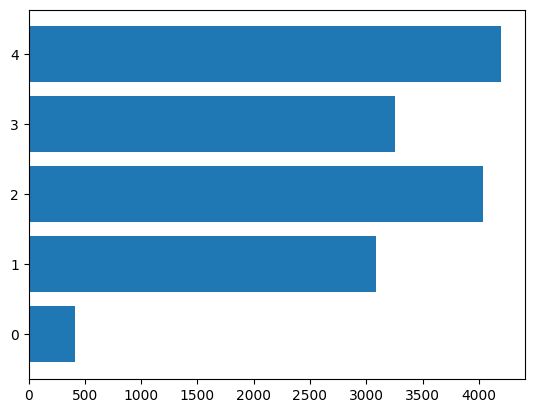

In [9]:
# Checking the distribution of adoption speed

Adoption_speed_counts = adoption_df_v3['AdoptionSpeed'].value_counts()
plt.barh(y=Adoption_speed_counts.index,width=Adoption_speed_counts.values)

<Axes: xlabel='HasName?', ylabel='PCT_Adoption_Speed'>

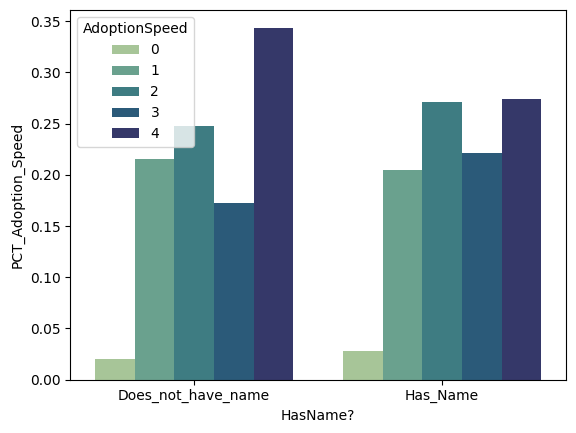

In [10]:
Name_graph = adoption_df_v3.groupby(['HasName?','AdoptionSpeed'])['PetID'].count().reset_index()
Name_graph = pd.merge(Name_graph, adoption_df_v3.groupby('HasName?')['PetID'].count().reset_index(), on='HasName?')

Name_graph['PCT_Adoption_Speed'] = Name_graph['PetID_x']/Name_graph['PetID_y']

sns.barplot(data=Name_graph, x='HasName?', y='PCT_Adoption_Speed', hue='AdoptionSpeed', palette='crest')

### 2.1 General & key variables

In this section, I'll be exploring the distribution of general variables. For example, the % of the animals in the dataset that are dogs and the % that are cats. We also want to get an idea about the gender and age of the animals listed for adoption:

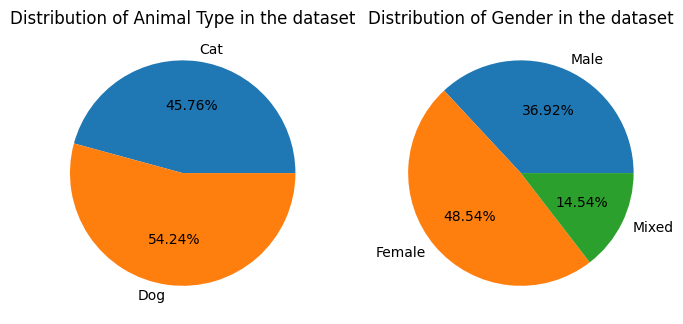

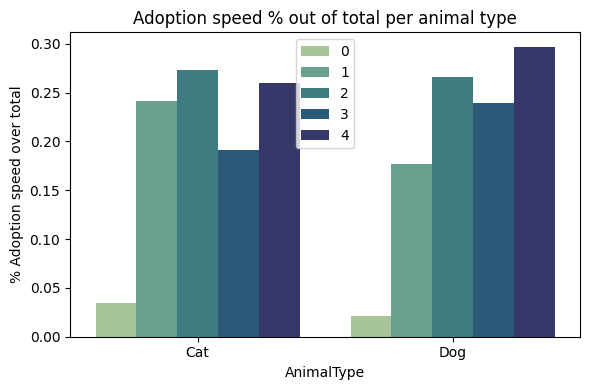

In [11]:

adoption_df_v3['AnimalType'] = np.where(adoption_df_v3['Type'] == 1, 'Dog','Cat') #Transforming the code, so it's easier to interpret later

Animal_Type_pie = adoption_df_v3.groupby('AnimalType')['PetID'].count().reset_index(name='Count_Type')
Gender_pie = adoption_df_v3.groupby('Gender')['PetID'].count().reset_index(name='Count_Gender')

# Plotting Pie chart for animal type and gender
fig, axes = plt.subplots(1,2,figsize=(8,6))
axes[0].pie(x=Animal_Type_pie['Count_Type'], labels=Animal_Type_pie['AnimalType'], autopct='%0.2f%%')
axes[1].pie(x=Gender_pie['Count_Gender'], labels=np.where(Gender_pie['Gender']== 1,'Male',np.where(Gender_pie['Gender']==2, 'Female','Mixed')), autopct='%0.2f%%')
axes[0].set_title('Distribution of Animal Type in the dataset')
axes[1].set_title('Distribution of Gender in the dataset')
plt.show()

# Plotting bar chart to see how fast animals get adopted based on animal type
Animal_Type_adoption = adoption_df_v3.groupby(['AnimalType','AdoptionSpeed'])['PetID'].count().reset_index()
Animal_Type_adoption = pd.merge(Animal_Type_adoption, adoption_df_v3.groupby('AnimalType')['PetID'].count().reset_index(), on='AnimalType')
Animal_Type_adoption['% Adoption speed over total'] = Animal_Type_adoption['PetID_x'] / Animal_Type_adoption['PetID_y']

plt.figure(figsize=(6,4))
sns.barplot(data=Animal_Type_adoption, x='AnimalType', y='% Adoption speed over total',hue='AdoptionSpeed', palette='crest')
plt.legend(loc='upper center')
plt.title('Adoption speed % out of total per animal type')
plt.tight_layout()

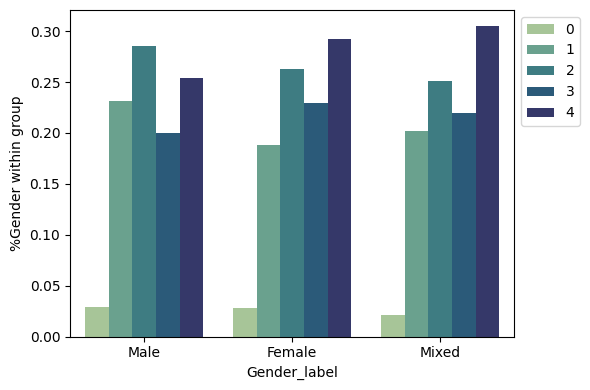

In [12]:
Gender_and_adoption = adoption_df_v3.groupby(['Gender','AdoptionSpeed'])['PetID'].count().reset_index(name='Count')
Gender_groupped2 = adoption_df_v3.groupby('Gender')['PetID'].count().reset_index(name='Total_of_gender_group')
Gender_and_adoption = pd.merge(Gender_and_adoption, Gender_groupped2, on='Gender')

Gender_and_adoption['%Gender within group'] = Gender_and_adoption['Count']/Gender_and_adoption['Total_of_gender_group']
Gender_and_adoption['Gender_label'] = np.where(Gender_and_adoption['Gender'] == 1, 'Male',np.where(Gender_and_adoption['Gender'] == 2, 'Female','Mixed'))

plt.figure(figsize=(6,4))
sns.barplot(data=Gender_and_adoption, x='Gender_label', y='%Gender within group', hue='AdoptionSpeed',palette='crest')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()

We can see from above graphs, that it seems like Cats generally get adopted faster than dogs. There is a common perception that cats might be easier for some lifestyles (e.g: a dog needs to be walked and cats not really). In terms of gender and adoption, we see that Female animals have a harder time to get adopted faster. This is probably because female animals can have "accidents" and come back with offsprings in comparison to male animals. Mixed gender means that the posting had more than 1 animal listed, and we can see that the adoption time is slower as well.

To analyze age, I am doing a cumulative table to see where most animals fall into in terms of age. It seems that half dataset actually falls into 0-3 months and 80% approx of the data is in 80%.

I also split per animal type to see the distribution of their ages.

    Age  PetID  Cumulative  Cumulative %
3     3   1966        7952      0.530381
4     4   1109        9061      0.604349
5     5    595        9656      0.644034
6     6    558       10214      0.681251
7     7    281       10495      0.699993
8     8    309       10804      0.720603
9     9    184       10988      0.732875
10   10    162       11150      0.743680
11   11     94       11244      0.749950
12   12    967       12211      0.814447
0.53 % of animals are actually 3 months or younger


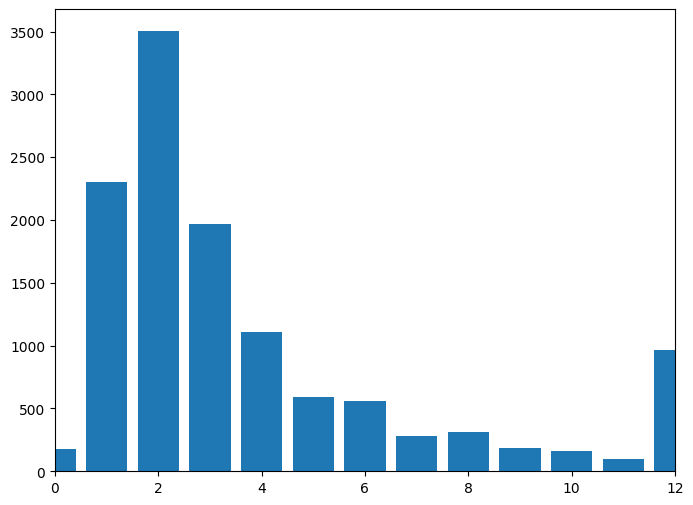

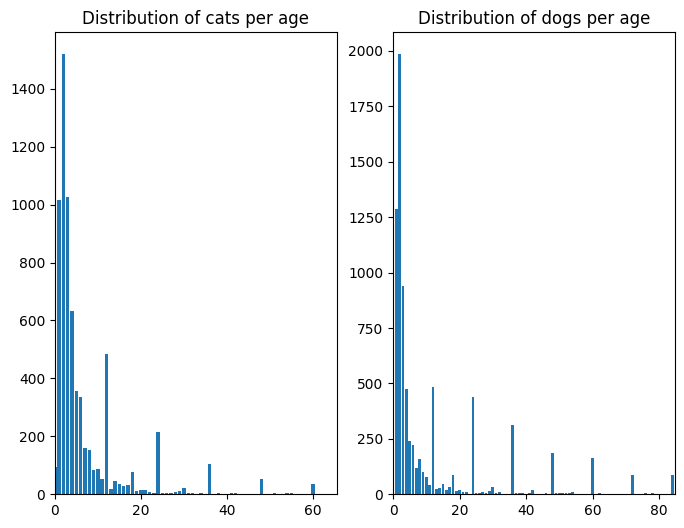

In [13]:
# Getting cumulative sum and cumulative %
Age_data = adoption_df_v2.groupby('Age')['PetID'].count().reset_index()
Age_data = Age_data.sort_values(by='Age')
Age_data['Cumulative'] = np.cumsum(Age_data['PetID'])
Age_data['Cumulative %'] = Age_data['Cumulative'] / len(adoption_df_v2)

print(Age_data[Age_data['Cumulative %'] >= 0.5].head(10))
Percentage_0_3 = Age_data[Age_data['Age'] == 3]['Cumulative %']
print(f'{round(Percentage_0_3.iloc[0],2)} % of animals are actually 3 months or younger')


# Plotting bars from 0-12 months of age of animals
age_values = adoption_df_v3['Age'].value_counts()
age_value_percentage = age_values.values / len(adoption_df_v2)

plt.figure(figsize=(8,6))
plt.bar(age_values.index, age_values.values)
plt.xlim(adoption_df_v3['Age'].min(), np.percentile(adoption_df_v2['Age'],75))

plt.show()

# Plotting for both cats and dogs:
age_dogs = adoption_df_v3[adoption_df_v3['AnimalType'] =='Dog'].groupby(['Age'])['PetID'].count().reset_index(name='Count')
age_cats = adoption_df_v3[adoption_df_v3['AnimalType'] =='Cat'].groupby(['Age'])['PetID'].count().reset_index(name='Count')

fig, axes = plt.subplots(1,2,figsize=(8,6))
axes[0].bar(x=age_cats['Age'], height= age_cats['Count'])
axes[1].bar(x=age_dogs['Age'], height= age_dogs['Count'])
axes[0].set_xlim(age_cats['Age'].min(), np.percentile(age_cats['Age'],75))
axes[1].set_xlim(age_dogs['Age'].min(), np.percentile(age_dogs['Age'],75))
axes[0].set_title('Distribution of cats per age')
axes[1].set_title('Distribution of dogs per age')
plt.show()

Lastly, I'm quickly checking whether we can spot any correlation between Adoption Speed with age. My hypothesis is that maybe older animals don't get adopted as much as people tend to adopt puppies and kittens. They have the perception that older animals might not accompany them forever.


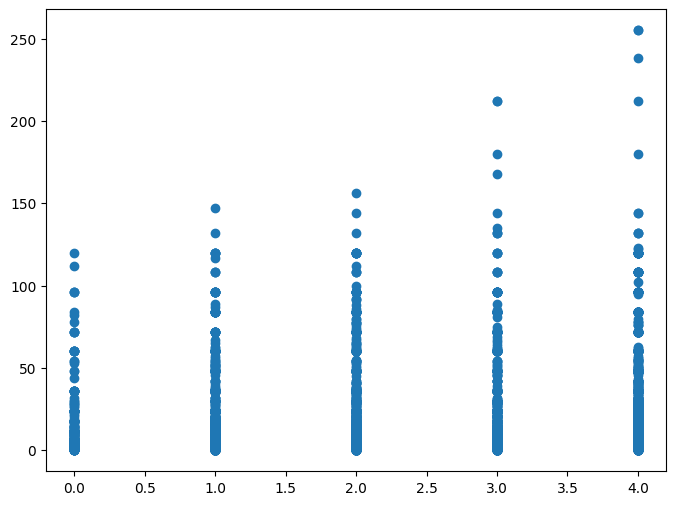

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(x=adoption_df_v3['AdoptionSpeed'], y=adoption_df_v3['Age'])

In [15]:
print(adoption_df_v3.groupby('AdoptionSpeed')['Age'].mean()) #Checking their mean very quickly.
pd.options.display.float_format = '{:.10f}'.format #For posterior p-values to not be displayed in scientific format

Adop_0_age = adoption_df_v3[adoption_df_v3['AdoptionSpeed'] == 0]['Age']
Adop_1_age = adoption_df_v3[adoption_df_v3['AdoptionSpeed'] == 1]['Age']
Adop_2_age = adoption_df_v3[adoption_df_v3['AdoptionSpeed'] == 2]['Age']
Adop_3_age = adoption_df_v3[adoption_df_v3['AdoptionSpeed'] == 3]['Age']
Adop_4_age = adoption_df_v3[adoption_df_v3['AdoptionSpeed'] == 4]['Age']

import scipy.stats as stats
import pingouin as pg

levene_stats, levene_p_val = stats.levene(Adop_0_age,Adop_1_age,Adop_2_age,Adop_3_age,Adop_4_age,center='median')
if levene_p_val < 0.05:
    print(f'p-value is {levene_p_val}, since it is less than 0.05 we conclude that there are differences in variance')
else:
    print(f'p-value is {levene_p_val}, since it is greayer than 0.05 we conclude that there are NO differences in variance')


# As there is no equal variance, I'm going to use Welch Anova using pingouin:
print()
Welch_anova_age_speed_results = pg.welch_anova(dv='Age', between='AdoptionSpeed', data=adoption_df_v3)
print(Welch_anova_age_speed_results)

# Game-Howell test as Welch-Anova was significant:
games_howell = pg.pairwise_gameshowell(dv='Age',between='AdoptionSpeed', data=adoption_df_v3)
print()
print(games_howell)

AdoptionSpeed
0    10.451220
1     8.488350
2     8.823631
3    10.189936
4    13.667858
Name: Age, dtype: float64
p-value is 2.8459492802745164e-26, since it is less than 0.05 we conclude that there are differences in variance

          Source  ddof1           ddof2             F        p-unc  \
0  AdoptionSpeed      4 2705.3315057661 46.7631307626 0.0000000000   

           np2  
0 0.0134053668  

   A  B       mean(A)       mean(B)          diff           se              T  \
0  0  1 10.4512195122  8.4883495146  1.9628699976 0.9224216985   2.1279529752   
1  0  2 10.4512195122  8.8236314095  1.6275881027 0.9167116608   1.7754635098   
2  0  3 10.4512195122 10.1899355631  0.2612839491 0.9368038323   0.2789099918   
3  0  4 10.4512195122 13.6678579938 -3.2166384816 0.9314647101  -3.4533122370   
4  1  2  8.4883495146  8.8236314095 -0.3352818949 0.3872712208  -0.8657547395   
5  1  3  8.4883495146 10.1899355631 -1.7015860485 0.4326894379  -3.9325805058   
6  1  4  8.4883495146 13.667

From the results we can see that our hypotheses of people preferring younger animals might be true. As we can see that groups 3 and 4 (specially 4) which represents higher adoption times or no adoption after 100 days of being listed, the avg age is higher!
This makes me conclude that older animals have it harder to be adopted.

For group 0, we have seen that its difference with group 1 and 2 is purely due to chance, so it's age difference is not significant.

### 2.2 Appearance related
In this section, I'll explore variables related to the appearance of the animal. Many people, when adopting might look for a specific breed, size or even whether the animal has long fur or not. There are many hypotheses that I can form:

1) People might want a pure breed
2) People might not want huge animals in their house but rather small ones
3) People might prefer short furred animals because it's easier to clean.
4) Color might be very important too! It is a susperstition that black cats bring bad luck, it would be interesting if in real practice people really do take that into consideration.


In [16]:
adoption_df_v3.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'HasName?',
       'Sentiment_score', 'Sentiment_magnitude', 'AnimalType'],
      dtype='object')

In [17]:
appearance_df = adoption_df_v3[['PetID','AdoptionSpeed','Breed1','Breed2','Color1','Color2','Color3','MaturitySize','FurLength','Type','AnimalType']]
appearance_df

,PetID,AdoptionSpeed,Breed1,Breed2,Color1,Color2,Color3,MaturitySize,FurLength,Type,AnimalType
0,86e1089a3,2,299,0,1,7,0,1,1,2,Cat
1,6296e909a,0,265,0,1,2,0,2,2,2,Cat
2,3422e4906,3,307,0,2,7,0,2,2,1,Dog
3,5842f1ff5,2,307,0,1,2,0,2,1,1,Dog
4,850a43f90,2,307,0,1,0,0,2,1,1,Dog
...,...,...,...,...,...,...,...,...,...,...,...
14988,dc0935a84,2,266,0,1,0,0,2,2,2,Cat
14989,a01ab5b30,4,265,264,1,4,7,2,2,2,Cat
14990,d981b6395,3,265,266,5,6,7,3,2,2,Cat
14991,e4da1c9e4,4,266,0,4,7,0,1,1,2,Cat


Whenever field is 0, it means that the animal doesn't have second breed or second color. So I'll see whether it's very common for animals to miss the second/third color and whether most of the animals are mixed or pure breed.

/tmp/ipykernel_369/2021002999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearance_df['PureColor'] = np.where(appearance_df['Color2'] == 0, 'Yes','No')


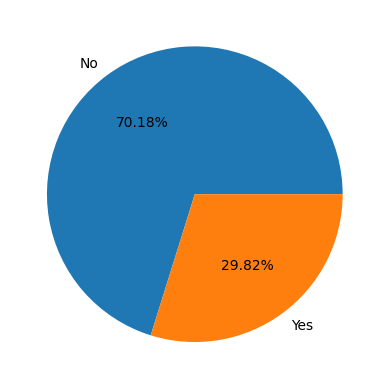

Percentage of color 2 missing is 0.2982058293870473, and percentage of color 3 missing is 0.7072633895818048


In [18]:
appearance_df['PureColor'] = np.where(appearance_df['Color2'] == 0, 'Yes','No')
pie_PureColor = appearance_df.groupby('PureColor')['PetID'].count()
plt.pie(pie_PureColor,labels=pie_PureColor.index,autopct='%0.2f%%')
plt.show()

percentage_no_color_2 = appearance_df[appearance_df['Color2'] == 0]['PetID'].count() / len(appearance_df)
percentage_no_color_3 = appearance_df[appearance_df['Color3'] == 0]['PetID'].count() / len(appearance_df)
print(f'Percentage of color 2 missing is {percentage_no_color_2}, and percentage of color 3 missing is {percentage_no_color_3}')



Since Color1 and Color2 are the main colors of the animal in adoption, they'll probably influence the adoption speed the most. I will disregard Color3 as 70% of the dataset is missing it and as said, I don't believe it's as important.



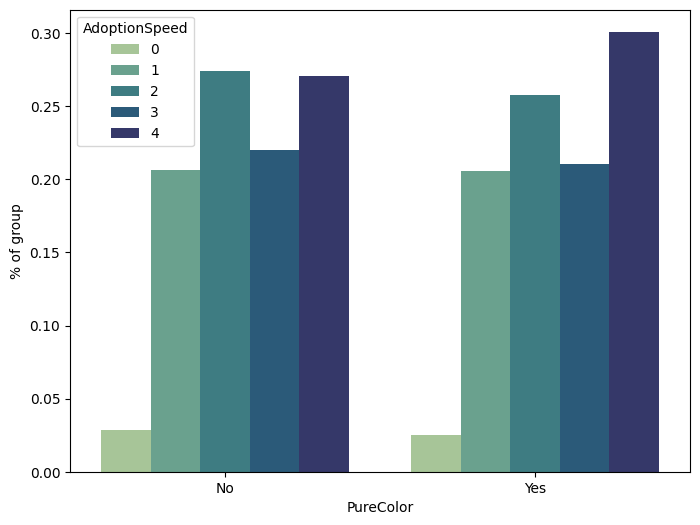

In [19]:
Color_and_adoption = appearance_df.groupby(['PureColor','AdoptionSpeed'])['PetID'].count().reset_index()
Color_group = appearance_df.groupby('PureColor')['PetID'].count().reset_index(name='GroupCount')
Color_and_adoption = pd.merge(Color_and_adoption, Color_group, on='PureColor')
Color_and_adoption['% of group'] = Color_and_adoption['PetID'] / Color_and_adoption['GroupCount']

plt.figure(figsize=(8,6))
sns.barplot(data=Color_and_adoption, x='PureColor',y='% of group', hue='AdoptionSpeed', palette='crest')
plt.show()

Hey it seems that pure colored animals have slightly higher "no adoption rate" (group 4)

In [20]:
#Now we're analyzing color spred and adoption speed

Color_pivot = appearance_df.pivot_table(index='Color1', columns='Color2', values='AdoptionSpeed', aggfunc='mean')
Color_pivot

Color2,0,2,3,4,5,6,7
Color1,,,,,,,
1,2.6666666667,2.5578025958,2.4074074074,2.6315789474,2.4461538462,2.3132911392,2.4930909091
2,2.6390410959,NaN,2.6323119777,2.6412556054,2.4204355109,2.5769230769,2.5726587729
3,2.4010840108,NaN,NaN,2.4509803922,2.5519480519,2.4202898551,2.2970297030
4,2.6448087432,NaN,NaN,NaN,2.4188034188,2.7384615385,2.5427509294
5,2.4244306418,NaN,NaN,NaN,NaN,2.1478260870,2.3111888112
6,2.4951140065,NaN,NaN,NaN,NaN,NaN,2.2891246684
7,2.3973013493,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Color2', ylabel='Color1'>

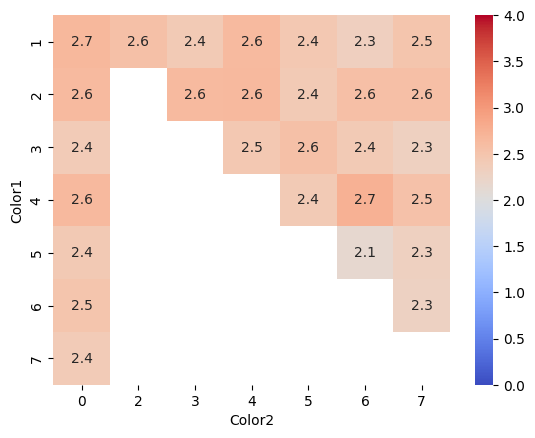

In [21]:
sns.heatmap(Color_pivot, annot=True, vmin=0, vmax=4, cmap='coolwarm')

As you can see from the heatmap, no specific color or mix of colors make adoption speed significantly faster.

Now, let's see the breed. I realized that some pets have the same input in Breed2 as Breed1. That means that they're pure breed, so I'll susbstitute those repeating Breed2s as 0 instead.

/tmp/ipykernel_369/3364549639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearance_df['Breed2'] = np.where(appearance_df['Breed1'] == appearance_df['Breed2'],0,appearance_df['Breed2'])
/tmp/ipykernel_369/3364549639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearance_df['PureBreed'] = np.where(appearance_df['Breed2'] == 0, 'Yes','No')


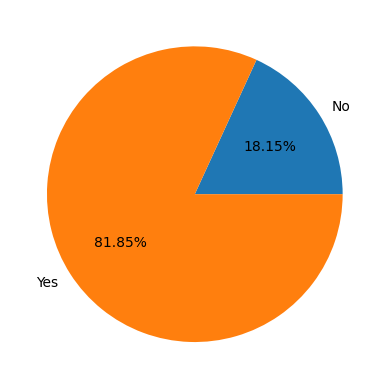

In [22]:
appearance_df['Breed2'] = np.where(appearance_df['Breed1'] == appearance_df['Breed2'],0,appearance_df['Breed2'])
appearance_df['PureBreed'] = np.where(appearance_df['Breed2'] == 0, 'Yes','No')

pie_PureBreed = appearance_df.groupby('PureBreed')['PetID'].count()
plt.pie(pie_PureBreed,labels=pie_PureBreed.index,autopct='%0.2f%%')
plt.show()

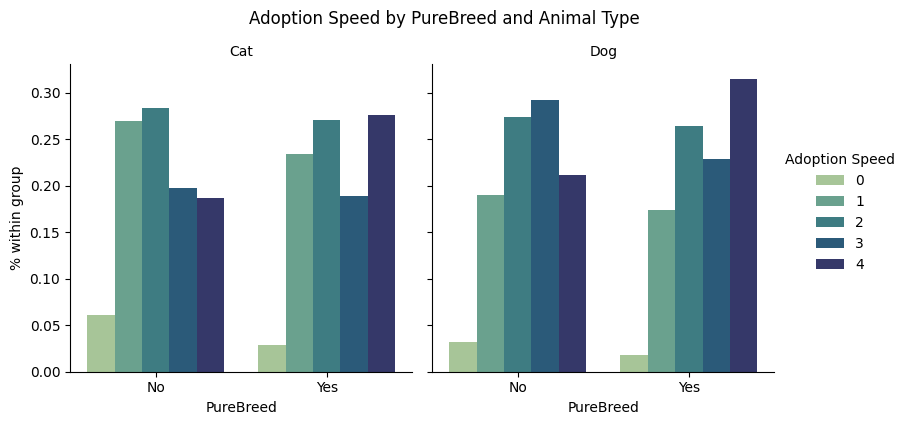

In [23]:
appearance_var_list = ['PureBreed']

def get_groupped_appvar(var_list, df):
    df_list = []
    for var in var_list:
        groupped = df.groupby(['AnimalType', var,'AdoptionSpeed'])['PetID'].count().reset_index(name='Count')
        globals()[f'{var}_df'] = groupped
        groupped2 = df.groupby(['AnimalType',var])['PetID'].count().reset_index(name='Total_group')
        globals()[f'{var}_df'] = pd.merge(globals()[f'{var}_df'], groupped2, on = ['AnimalType',var])
        globals()[f'{var}_df']['% within group'] = globals()[f'{var}_df']['Count']/globals()[f'{var}_df']['Total_group']
        df_list.append(globals()[f'{var}_df'])
    
    return df_list

dfs_to_plot = get_groupped_appvar(appearance_var_list,appearance_df) # Using the function

# Second function to plot the different dataframes I have obtained
def plot_each_health_var(list_df,var_list):

    for df,var in zip(list_df, var_list):

        g = sns.FacetGrid(df, col='AnimalType', col_wrap=2, height=4, sharey=True)

# Map the barplot onto the grid
        g.map_dataframe(sns.barplot, x=var, y='% within group', hue='AdoptionSpeed', palette='crest', errorbar=None)

        # Customize plots
        g.set_axis_labels(var, '% within group')
        g.set_titles(col_template="{col_name}")
        g.add_legend(title=f'Adoption Speed')
        g.fig.suptitle(f'Adoption Speed by {var} and Animal Type', y=1.05)
        plt.show()

plot_each_health_var(dfs_to_plot, appearance_var_list)


It is quite unexpected as we see that when the dog and cat are pure breeds, they get adopted less often! Normally we would expect otherwise. However, when we think about the nature of people that will pursue a pure breed, they will probably buy it and not adopt it.

In [24]:
Breed_labels_df = pd.read_csv('/home/ecotears/Ironhack/Ironhack_all/Ironhack_Final_Project/Datasets/CSV files/BreedLabels.csv')
appearance_df = pd.merge(appearance_df, Breed_labels_df, left_on=['Breed1','Type'], right_on=['BreedID','Type'], how='left')
appearance_df = pd.merge(appearance_df, Breed_labels_df, left_on=['Breed2','Type'], right_on=['BreedID','Type'], how='left')

In [25]:
appearance_df = appearance_df.drop(columns=['BreedID_x','BreedID_y'])
appearance_df.head(5)


,PetID,AdoptionSpeed,Breed1,Breed2,Color1,Color2,Color3,MaturitySize,FurLength,Type,AnimalType,PureColor,PureBreed,BreedName_x,BreedName_y
0,86e1089a3,2,299,0,1,7,0,1,1,2,Cat,No,Yes,Tabby,NaN
1,6296e909a,0,265,0,1,2,0,2,2,2,Cat,No,Yes,Domestic Medium Hair,NaN
2,3422e4906,3,307,0,2,7,0,2,2,1,Dog,No,Yes,Mixed Breed,NaN
3,5842f1ff5,2,307,0,1,2,0,2,1,1,Dog,No,Yes,Mixed Breed,NaN
4,850a43f90,2,307,0,1,0,0,2,1,1,Dog,Yes,Yes,Mixed Breed,NaN


/tmp/ipykernel_369/161490850.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=Breed_indepth_dog_morethan10.head(10)['Breed-mix'], rotation=90)
/tmp/ipykernel_369/161490850.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=Breed_indepth_dog_morethan10.tail(10)['Breed-mix'], rotation=90)


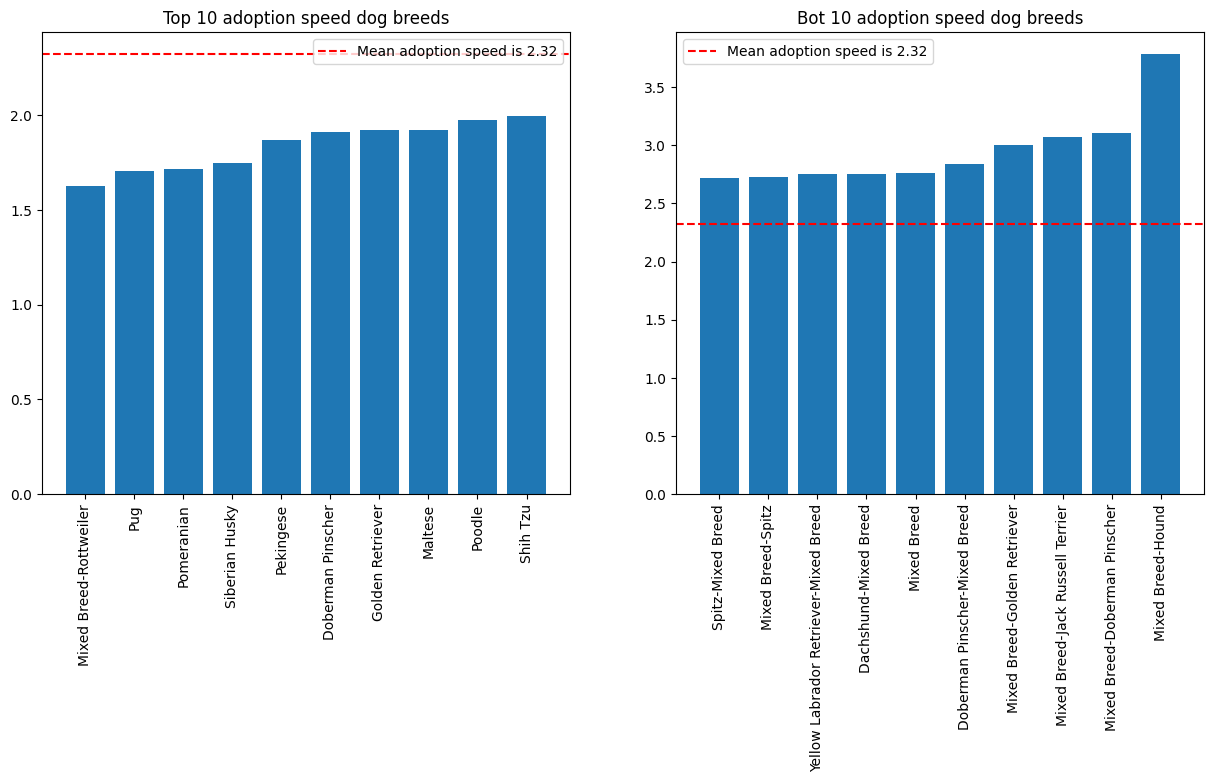

In [26]:
appearance_df['Breed-mix'] = np.where(appearance_df['Breed2']!= 0, appearance_df['BreedName_x'] + '-' + appearance_df['BreedName_y'], appearance_df['BreedName_x'])
Breed_indepth_dog = appearance_df[appearance_df['Type'] == 1].groupby(['Breed1','Breed-mix']).agg({'PetID':'count','AdoptionSpeed':'mean'}).sort_values(by='PetID')
Breed_indepth_dog_morethan10 = Breed_indepth_dog[Breed_indepth_dog['PetID'] > 10].reset_index().sort_values(by='AdoptionSpeed')

#Hey we maybe should take into account only animals above certain threshold? LIke 10??
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].bar(x=Breed_indepth_dog_morethan10.head(10)['Breed-mix'], height=Breed_indepth_dog_morethan10.head(10)['AdoptionSpeed'])
axes[0].set_xticklabels(labels=Breed_indepth_dog_morethan10.head(10)['Breed-mix'], rotation=90)
axes[0].axhline(y=Breed_indepth_dog_morethan10['AdoptionSpeed'].mean(), color='red', linestyle='--', label=f"Mean adoption speed is {round(Breed_indepth_dog_morethan10['AdoptionSpeed'].mean(),2)}")
axes[0].legend()
axes[0].set_title('Top 10 adoption speed dog breeds')

axes[1].bar(x=Breed_indepth_dog_morethan10.tail(10)['Breed-mix'], height=Breed_indepth_dog_morethan10.tail(10)['AdoptionSpeed'])
axes[1].set_xticklabels(labels=Breed_indepth_dog_morethan10.tail(10)['Breed-mix'], rotation=90)
axes[1].axhline(y=Breed_indepth_dog_morethan10['AdoptionSpeed'].mean(), color='red', linestyle='--', label=f"Mean adoption speed is {round(Breed_indepth_dog_morethan10['AdoptionSpeed'].mean(),2)}")
axes[1].legend()
axes[1].set_title('Bot 10 adoption speed dog breeds')
plt.show()




/tmp/ipykernel_369/2312882024.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=Breed_indepth_cat_morethan10.head(10)['Breed-mix'], rotation=90)
/tmp/ipykernel_369/2312882024.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=Breed_indepth_cat_morethan10.tail(10)['Breed-mix'], rotation=90)


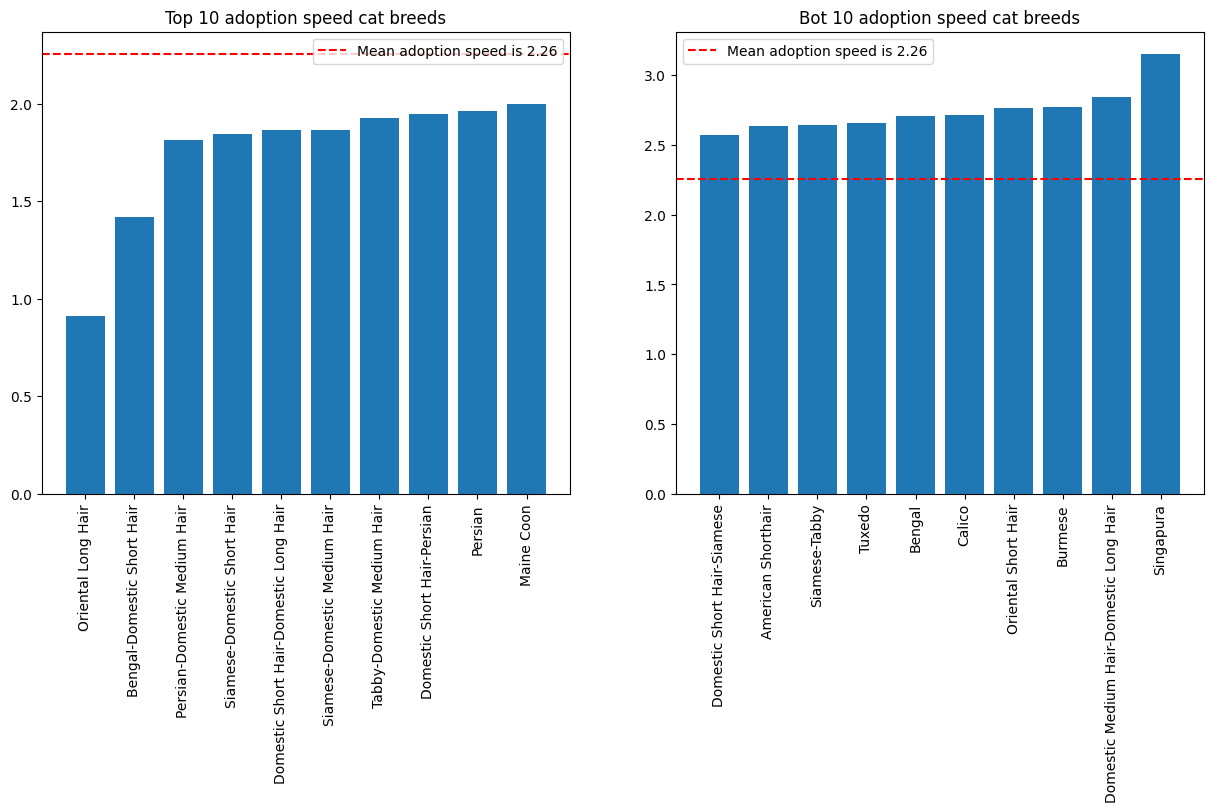

In [27]:
Breed_indepth_cat = appearance_df[appearance_df['Type'] == 2].groupby(['Breed1','Breed-mix']).agg({'PetID':'count','AdoptionSpeed':'mean'}).sort_values(by='PetID')
Breed_indepth_cat_morethan10 = Breed_indepth_cat[Breed_indepth_cat['PetID'] > 10].reset_index().sort_values(by='AdoptionSpeed')

#Hey we maybe should take into account only animals above certain threshold? LIke 10??
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].bar(x=Breed_indepth_cat_morethan10.head(10)['Breed-mix'], height=Breed_indepth_cat_morethan10.head(10)['AdoptionSpeed'])
axes[0].set_xticklabels(labels=Breed_indepth_cat_morethan10.head(10)['Breed-mix'], rotation=90)
axes[0].axhline(y=Breed_indepth_cat_morethan10['AdoptionSpeed'].mean(), color='red', linestyle='--', label=f"Mean adoption speed is {round(Breed_indepth_cat_morethan10['AdoptionSpeed'].mean(),2)}")
axes[0].legend()
axes[0].set_title('Top 10 adoption speed cat breeds')

axes[1].bar(x=Breed_indepth_cat_morethan10.tail(10)['Breed-mix'], height=Breed_indepth_cat_morethan10.tail(10)['AdoptionSpeed'])
axes[1].set_xticklabels(labels=Breed_indepth_cat_morethan10.tail(10)['Breed-mix'], rotation=90)
axes[1].axhline(y=Breed_indepth_cat_morethan10['AdoptionSpeed'].mean(), color='red', linestyle='--', label=f"Mean adoption speed is {round(Breed_indepth_cat_morethan10['AdoptionSpeed'].mean(),2)}")
axes[1].legend()
axes[1].set_title('Bot 10 adoption speed cat breeds')
plt.show()


For fur length and Maturity Size, I will group the dogs & cats by adoption speed and the respective variable to spot whether there are clear differences or patterns in adoption speed when it comes to maturity size and fur length.

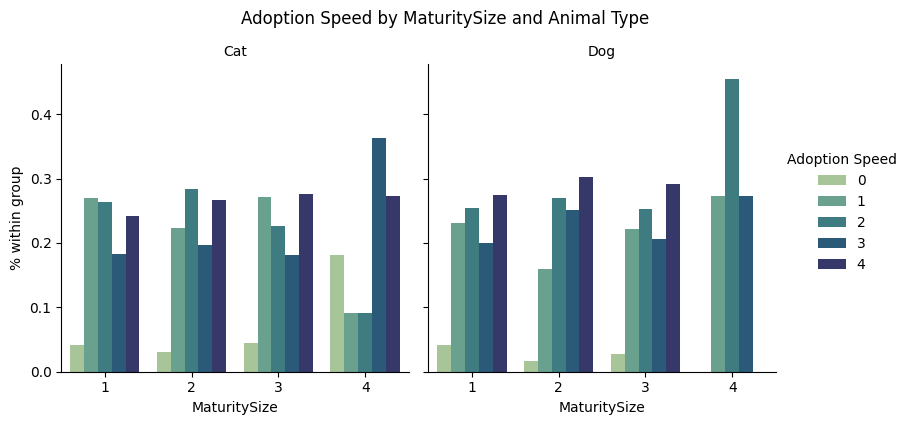

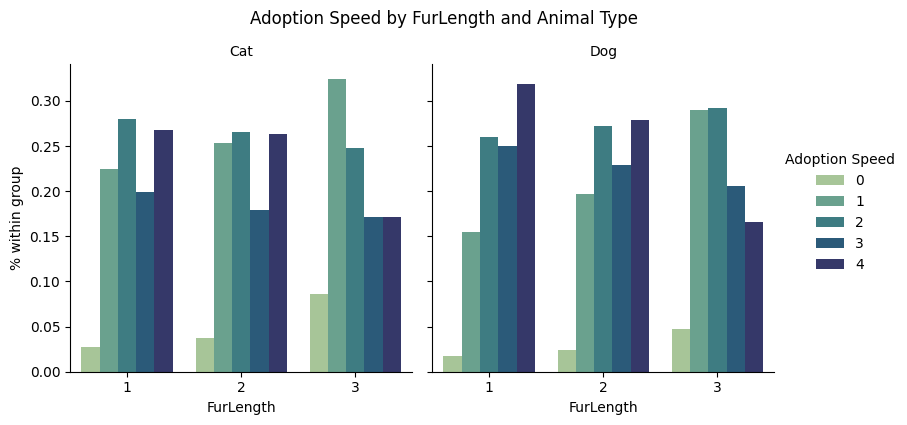

In [28]:
appearance_var_list = ['MaturitySize','FurLength']

def get_groupped_appvar(var_list, df):
    df_list = []
    for var in var_list:
        groupped = df.groupby(['AnimalType', var,'AdoptionSpeed'])['PetID'].count().reset_index(name='Count')
        globals()[f'{var}_df'] = groupped
        groupped2 = df.groupby(['AnimalType',var])['PetID'].count().reset_index(name='Total_group')
        globals()[f'{var}_df'] = pd.merge(globals()[f'{var}_df'], groupped2, on = ['AnimalType',var])
        globals()[f'{var}_df']['% within group'] = globals()[f'{var}_df']['Count']/globals()[f'{var}_df']['Total_group']
        df_list.append(globals()[f'{var}_df'])
    
    return df_list

dfs_to_plot = get_groupped_appvar(appearance_var_list,adoption_df_v3) # Using the function

# Second function to plot the different dataframes I have obtained
def plot_each_health_var(list_df,var_list):

    for df,var in zip(list_df, var_list):

        g = sns.FacetGrid(df, col='AnimalType', col_wrap=2, height=4, sharey=True)

# Map the barplot onto the grid
        g.map_dataframe(sns.barplot, x=var, y='% within group', hue='AdoptionSpeed', palette='crest', errorbar=None)

        # Customize plots
        g.set_axis_labels(var, '% within group')
        g.set_titles(col_template="{col_name}")
        g.add_legend(title=f'Adoption Speed')
        g.fig.suptitle(f'Adoption Speed by {var} and Animal Type', y=1.05)
        plt.show()

plot_each_health_var(dfs_to_plot, appearance_var_list)

We can see that in terms of size, it's pretty similar or no clear trend can be seen when the animals are sizes small to large. But when it's extra large, we can see that dogs are much favoured and adopted much quicker than cats. It seems that extra-large cats have a harder time in getting adopted. When it comes to fur length, it seems that the popular opinion is to prefer longer fur as we can see that in both cats and dogs, the groups of long adoption get smaller as fur gets longer.

### 2.3 Health related variables

In this section, I'll analyze Health related variables to both understand if there's any trends regarding health-related issues (vaccination, deworming, etc.) as well as trying to understand if health has anything to do with adoption speed:


In [29]:
adoption_df_v3['Vaccinated']

0        2
1        3
2        1
3        1
4        2
        ..
14988    2
14989    1
14990    2
14991    1
14992    2
Name: Vaccinated, Length: 14993, dtype: int64

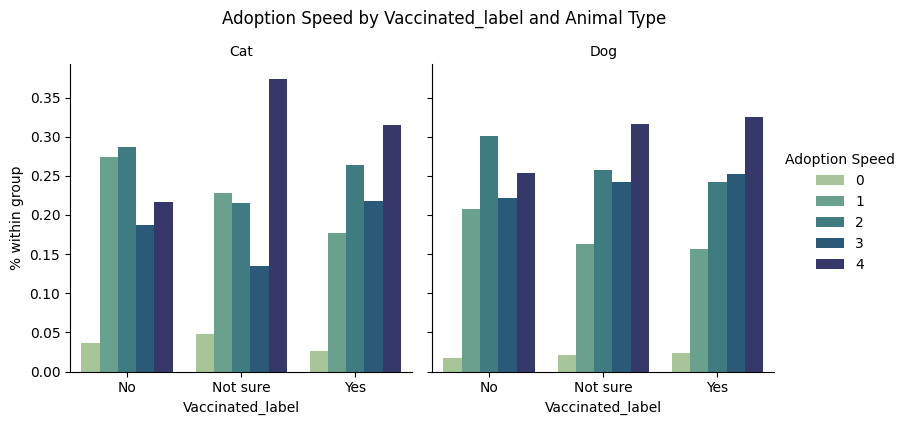

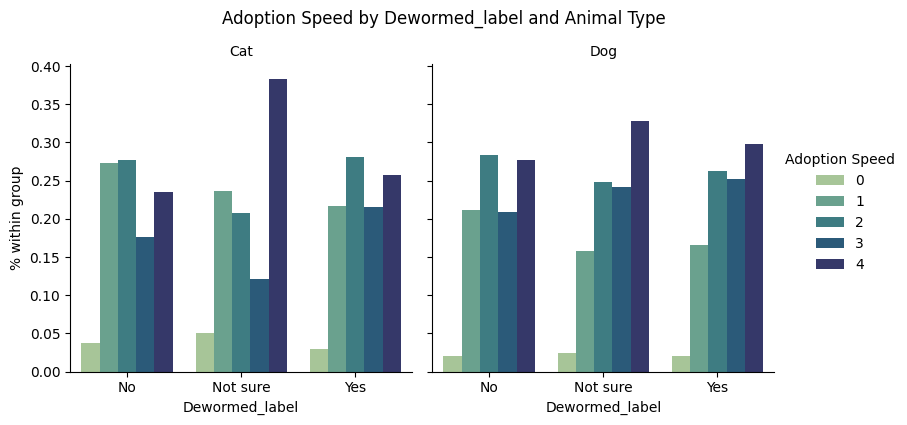

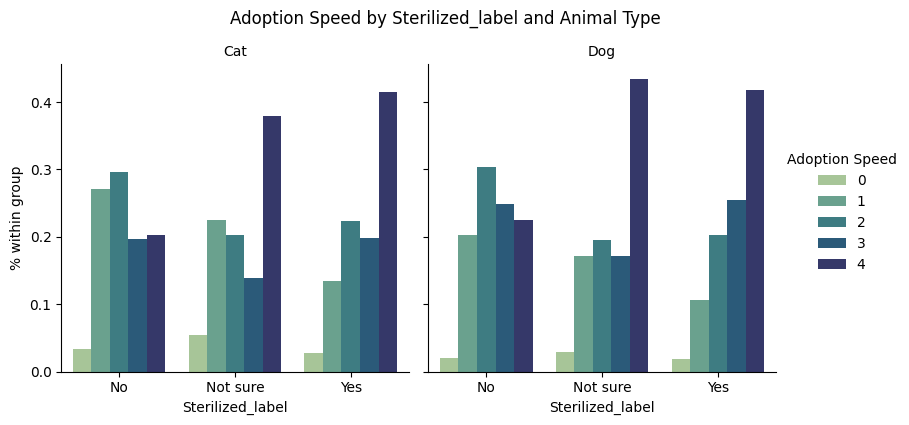

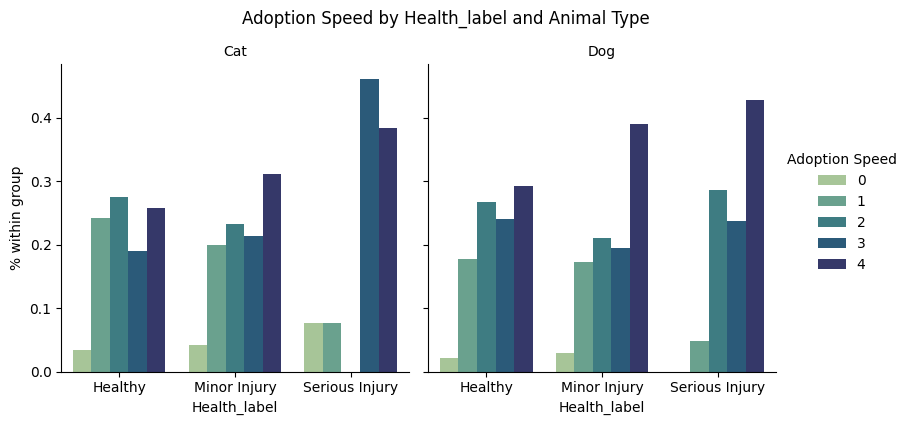

In [30]:
# Putting the labels back to encoded variables
adoption_df_v3['Vaccinated_label'] = np.where(adoption_df_v3['Vaccinated'] == 1,'Yes',np.where(adoption_df_v3['Vaccinated'] == 2,'No','Not sure'))
adoption_df_v3['Dewormed_label'] = np.where(adoption_df_v3['Dewormed'] == 1,'Yes',np.where(adoption_df_v3['Dewormed'] == 2,'No','Not sure'))
adoption_df_v3['Sterilized_label'] = np.where(adoption_df_v3['Sterilized'] == 1,'Yes',np.where(adoption_df_v3['Sterilized'] == 2,'No','Not sure'))
adoption_df_v3['Health_label'] = np.where(adoption_df_v3['Health'] == 1,'Healthy',np.where(adoption_df_v3['Health'] == 2,'Minor Injury',np.where(adoption_df_v3['Health'] == 3,'Serious Injury','Not specified')))

# First function to get dataframes in a specific format for plotting later
health_variable_list = ['Vaccinated_label','Dewormed_label','Sterilized_label','Health_label']

def get_groupped_healthvar(var_list, df):
    df_list = []
    for var in var_list:
        groupped = df.groupby(['AnimalType', var,'AdoptionSpeed'])['PetID'].count().reset_index(name='Count')
        globals()[f'{var}_df'] = groupped
        groupped2 = df.groupby(['AnimalType',var])['PetID'].count().reset_index(name='Total_group')
        globals()[f'{var}_df'] = pd.merge(globals()[f'{var}_df'], groupped2, on = ['AnimalType',var])
        globals()[f'{var}_df']['% within group'] = globals()[f'{var}_df']['Count']/globals()[f'{var}_df']['Total_group']
        df_list.append(globals()[f'{var}_df'])
    
    return df_list

dfs_to_plot = get_groupped_healthvar(health_variable_list,adoption_df_v3) # Using he function

# Second function to plot the different dataframes I have obtained
def plot_each_health_var(list_df,var_list):

    for df,var in zip(list_df, var_list):

        g = sns.FacetGrid(df, col='AnimalType', col_wrap=2, height=4, sharey=True)

# Map the barplot onto the grid
        g.map_dataframe(sns.barplot, x=var, y='% within group', hue='AdoptionSpeed', palette='crest', errorbar=None)

        # Customize plots
        g.set_axis_labels(var, '% within group')
        g.set_titles(col_template="{col_name}")
        g.add_legend(title=f'Adoption Speed')
        g.fig.suptitle(f'Adoption Speed by {var} and Animal Type', y=1.05)
        plt.show()

plot_each_health_var(dfs_to_plot, health_variable_list)



Here are my initial hypothesis for each of the health-related variables and then the actual pattern I saw:

1)**Vaccinated:** I would assume that people really cares whether the animal comes vaccinated or not so I would expect faster adoptions (groups 0-2) for Animals that are adopted. However, by observing the graph, we see that even if animals are adopted, the group 3-4 (slow adoption) is still quite large. Interesting thing is that the % of 4 is higher in vaccinated animals for both cats and dogs. This might indicate that my initial theory is not true.
It appears that when people don't know whether the animals have received the vaccine or not, could cause the adoption speed to be slower (this might be because you need to follow certain procedures when vaccinating, like several rounds, and without knowing if there was a first round or when, makes it harder)

2)**Dewormed:** Similar to my assumption with vaccinated, I would expect animals that are dewormed to be adopted faster than those that are not. Similar to Vaccinated results, there doesn't seem to be a clear trend that not-dewormed animal get adopted slower. However, the not sure category does indeed spike up the group 4 (very slow adoption). This might be because of what we assumed earlier, deworming rounds need to happen within specific recommended periods, without knowing the first one could be harmful.

3)**Sterilized:** There are quite a lot of people that see sterilizing as "not-natural" and also many want to have offsprings of the animal. And here you can see that the adoption gets significantly slower (group 4, and sometimes 3 spikes) when the animal is spayed or neutered!

4)**Health:** I expected animals with worse conditions (health issues) to be adopted slower. And in the case of cats, you can see that with serious injury, the spikes for group 3 and 4 are insane. For dogs, you can see that the group 4 also increases the more unhealthier it is.

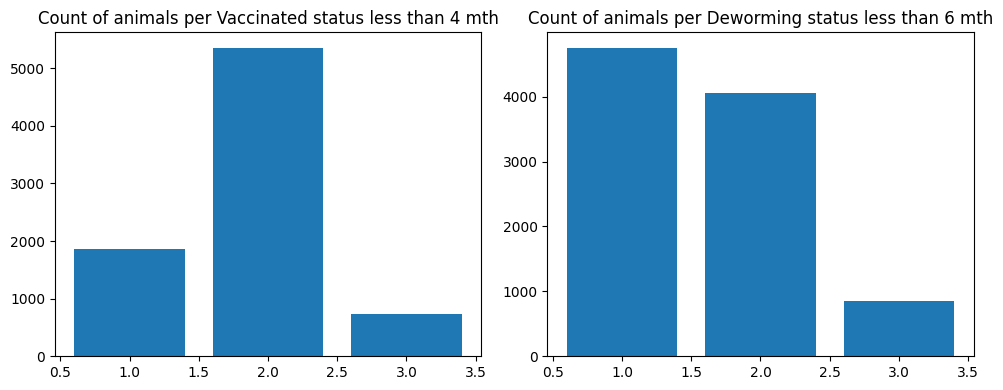

In [31]:
Less_than_4mth = adoption_df_v3[adoption_df_v3['Age']<4]
Vaccine_less4 = Less_than_4mth.groupby('Vaccinated')['PetID'].count().reset_index(name='Count')

Less_than_6mth = adoption_df_v3[adoption_df_v3['Age']<6]
Deworming_less6 = Less_than_6mth.groupby('Dewormed')['PetID'].count().reset_index(name='Count')

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].bar(x=Vaccine_less4['Vaccinated'], height=Vaccine_less4['Count'])
axes[0].set_title('Count of animals per Vaccinated status less than 4 mth')
axes[1].bar(x=Deworming_less6['Dewormed'], height=Deworming_less6['Count'])
axes[1].set_title('Count of animals per Deworming status less than 6 mth')
plt.tight_layout()
plt.show()

After some more digging, I realized that the relationship might not be what I initially thought. The majority of the dataset consists of animals of rather young age, we have seen that around 60% of animals are 4 months or younger. Puppies or kittens can only be vaccinated once they reach 4 months and dewormed once they reach 5-6 months. In fact, we can see that there are more than 5k animals not vaccinated for those age less than 4 months! (which is normal, as they shouldn't be counted as TOTALLY vaccinated in less than 4 mth). Therefore, the relationship might be simply that younger animals are adopted quickly and as a consequence, we have higher adoption speed for NOT vaccinated animals. So this status is actually a consequence!

### 2.4 Informational elements

In this section, I'll analyze the variable that provides additional information and is also "artificial". In other words, these variables depend heavily on the ad poster and the effort the person has put into the posting of the animal.

Hypothetically, I would expect that, the more effort someone puts into the animal posting (so, uploading more photoes, videos and writing a better description, perhaps with a positive tone) should impact whether the animal gets adopted faster or not.



In [32]:
Info_var = adoption_df_v3.groupby('AdoptionSpeed')[['VideoAmt','PhotoAmt','Sentiment_score','Sentiment_magnitude']].mean()
Info_var

,VideoAmt,PhotoAmt,Sentiment_score,Sentiment_magnitude
AdoptionSpeed,,,,
0,0.0609756098,3.3243902439,0.2773170732,1.7000000000
1,0.0449838188,3.7271844660,0.2544660194,2.0158252427
2,0.0634134258,4.0718355214,0.2655684915,2.1060936339
3,0.0727216938,4.6207425591,0.2674440012,2.2250383553
4,0.0462234930,3.3199904694,0.2892065761,1.9174648558


By looking at the table above, there doesn't seem to be a clear indicator of whether the sentiment score or the magnitude of the description caused a faster or slower adoption. In addition, we can't obtain clear results from VideoAmt variable either.

Now, regarding photoes, it appears that for some reason, with more photoes, the adoption gets slower! Adoption speed group 3 has on average a much higher amount of pictures. Indicating that even though it has many pictures of the animals, their adoption has been slow. But then, we have contradicting information for group 4, as it seems that it has the least pictures.

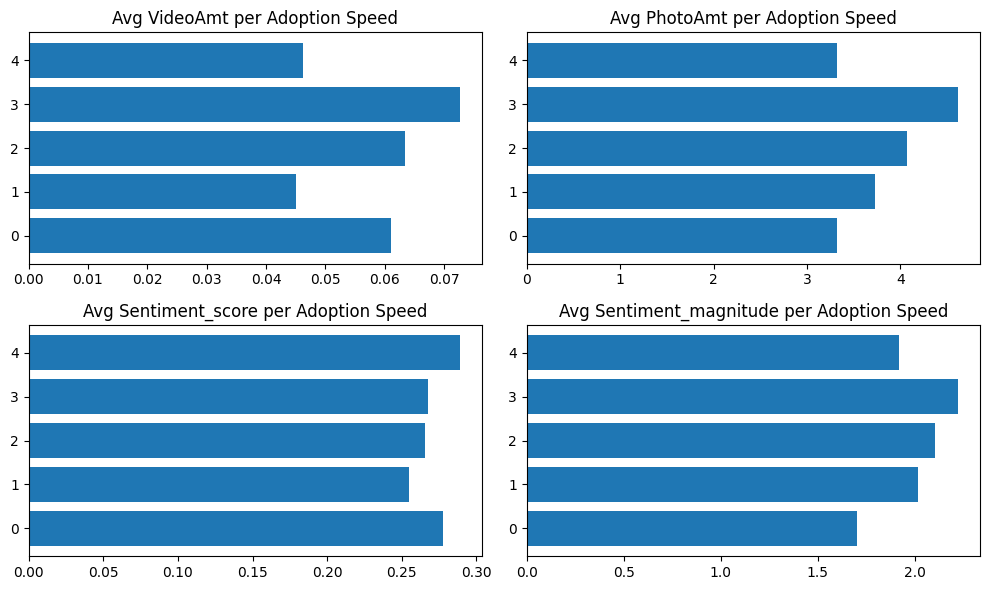

In [33]:
fig, axes = plt.subplots(2,2,figsize=(10,6))
axes = axes.flatten()
for n, var in enumerate(Info_var.columns):
    axes[n].barh(y=Info_var.index, width=Info_var[var])
    axes[n].set_title(f'Avg {var} per Adoption Speed')

plt.tight_layout()

In [34]:
pd.set_option('display.max_colwidth', None)
adoption_df_v3[adoption_df_v3['Sentiment_score']<-0.5][['Sentiment_score','Description']].reset_index().head(10)

,index,Sentiment_score,Description
0,290,-0.7000000000,I can't manage to have a lot of cats to take care.owner neglect her kitten n mother in front my house n don't want to take care of them.she want to dump this cats at market because she don't want them.so plz help me adopt this kitten and take a good care
1,477,-0.7000000000,Looking for a home for popo Don't have the time to take care of her
2,489,-0.7000000000,"The female dog is very pity, she stay at Uncle Kok 's house,she dislike of other dogs,last 2 week she had borned 11 pupies, but now the pupies all died already.Hope someone dog lover can take care of the her. Who interested can call to Uncle Kok by this No: or to Belinda:"
3,518,-0.8000000000,i'm looking for a new owner for my cat A.S.A.P b'coz i'm not able to take care of them in a small flat anymore..it is not a proper place to keep my pets.curerently i had 7 of them in my house and i had no one to take care of them while i'm working or outstation..anyone interested can contact me..
4,677,-0.7000000000,Rescued as one of her siblings is inflected maggot wounds and their staying place is very close to a heavy traffic main road from Hulu Langat to Kuala Lumpur
5,1152,-0.6000000000,This stray cat give birth to 3 kitten but 2 died left only this one. My friend can't keep and was hoping someone can take good care of it.
6,1233,-0.9000000000,Active young puppies in search of new home.Lady owner just neglect puppies with mother dog outside house near main road.
7,1305,-0.6000000000,Bailey is an obedient and loyal dog Her owner is terminaaly ill and is unable to care for her
8,1389,-0.8000000000,"He's been caged, owner too busy to care for him thus he's not friendly, very scared."
9,1491,-0.6000000000,"Hi, I'm looking for responsible new owner for my girl as i no longer able to look after her i'll be moving to over sea and need someone to adopt her ASAP Email me at"


Upon further digging, it seems that negative sentences most of the times do not describe the animal itself. See below examples:

1) "I can't manage to have a lot of cats to take care.owner neglect her kitten n mother in front my house n don't want to take care of them.she want to dump this cats at market because she don't want them.so plz help me adopt this kitten and take a good care"
2) "He's been caged, owner too busy to care for him thus he's not friendly, very scared.."
3) "Active young puppies in search of new home.Lady owner just neglect puppies with mother dog outside house near main road."

As can be seen, the negative score probably comes from some of the context description on how they were abandoned or that the poster's situation won't allow them to keep the animal. In this case, I don't think Sentiment analysis will be too useful for model prediction as both positive or "negative" reviews could prompt to faster adoptions. I will keep the variables for now and see later with feature enegineering.

In [35]:
Continuous_variables = ['Age', 'VideoAmt', 'PhotoAmt', 'Quantity', 'Fee','AdoptionSpeed'] 
Correlation_matrix = adoption_df_v2[Continuous_variables].corr(method='spearman') #Spearman is a good way to measure correlation with ordinal data.

### 2.5 Miscellaneous

In this section, I'll be exploring the variables that are left, quantity and fee of the adoption. 
My initial theory is that the higher the quantity of pets given for adoption, the slower it is. 
Fee is a variable that I'm not sure what to expect as typically, whenever there is a fee it is to cover medical expenses and/or vaccines. So it could go both ways.

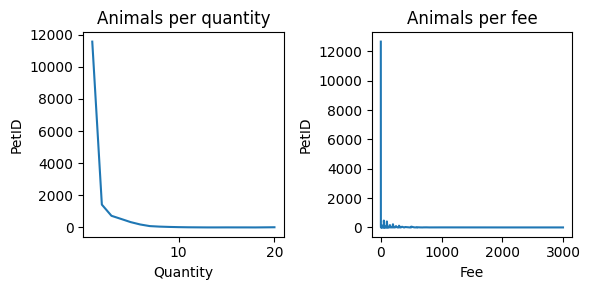

   Quantity  PetID
0         1  11565
1         2   1422
2         3    726
3         4    531
4         5    333
   Fee  PetID
0    0  12663
1    1     82
2    2      1
3    5     24
4    8      7
0.8003735076368972


In [36]:
Pets_per_quantity = adoption_df_v3.groupby('Quantity')['PetID'].count().reset_index()
Pets_per_fee = adoption_df_v3.groupby('Fee')['PetID'].count().reset_index()

fig, axes = plt.subplots(1,2,figsize=(6,3))
sns.lineplot(data=Pets_per_quantity, x='Quantity', y='PetID', ax=axes[0])
axes[0].set_title('Animals per quantity')
sns.lineplot(data=Pets_per_fee, x='Fee', y='PetID', ax=axes[1])
axes[1].set_title('Animals per fee')
plt.tight_layout()
plt.show()


print(Pets_per_quantity.head(5))
print(Pets_per_fee.head(5))
print(12000/len(adoption_df_v3))

We can see that most data or animals are only quantity 1 (meaning one pet being given out for adoption) and then for free. Looking closer they're both approximately 12k, which means 80% of the whole dataset.

Text(0.5, 1.0, 'Adoption Speed and Quantity')

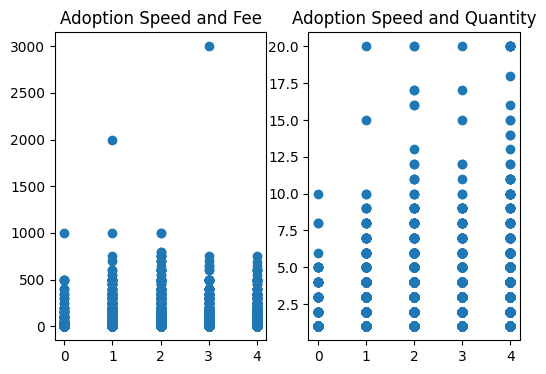

In [37]:
fig, axes = plt.subplots(1,2,figsize=(6,4))

axes[0].scatter(x=adoption_df_v3['AdoptionSpeed'], y=adoption_df_v3['Fee'])
axes[0].set_title('Adoption Speed and Fee')
axes[1].scatter(x=adoption_df_v3['AdoptionSpeed'], y=adoption_df_v3['Quantity'])
axes[1].set_title('Adoption Speed and Quantity')


Based on this, I don't see a specific trend of more fee implying lower adoption speed. And in terms of quantity, it is true that there are more points in adoption group 4 of higher quantities but I see that there are large groups adopted quite fast as well.

In [38]:
groupped_counts = adoption_df_v2.groupby(['MaturitySize','AdoptionSpeed'])['AdoptionSpeed'].count().reset_index(name='Count')

sum_each_group = groupped_counts.groupby(['MaturitySize'])['Count'].sum().reset_index(name='Total_within_group')

merged = pd.merge(groupped_counts, sum_each_group, on='MaturitySize')

merged['% of group total'] = merged['Count']/merged['Total_within_group']

merged

,MaturitySize,AdoptionSpeed,Count,Total_within_group,% of group total
0,1,0,139,3395,0.0409425626
1,1,1,870,3395,0.2562592047
2,1,2,884,3395,0.2603829161
3,1,3,641,3395,0.1888070692
4,1,4,861,3395,0.2536082474
5,2,0,226,10305,0.0219311014
6,2,1,1909,10305,0.1852498787
7,2,2,2837,10305,0.2753032508
8,2,3,2360,10305,0.2290150412
9,2,4,2973,10305,0.2885007278


## 3. Building the model

Once finished our exploratory data analysis, we can go ahead to build out and test some models, trying to obtain the best model overall.

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectFromModel
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

### 3.1 Preprocessing & Feature Engineering

In [123]:
adoption_df_model = adoption_df_v3.copy()
adoption_df_model.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'HasName?',
       'Sentiment_score', 'Sentiment_magnitude', 'AnimalType',
       'Vaccinated_label', 'Dewormed_label', 'Sterilized_label',
       'Health_label'],
      dtype='object')

In [124]:
color_df = pd.read_csv('/home/ecotears/Ironhack/Ironhack_all/Ironhack_Final_Project/Datasets/CSV files/ColorLabels.csv')
Breed_df = pd.read_csv('/home/ecotears/Ironhack/Ironhack_all/Ironhack_Final_Project/Datasets/CSV files/BreedLabels.csv')

In [125]:
adoption_df_model.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,PhotoAmt,AdoptionSpeed,HasName?,Sentiment_score,Sentiment_magnitude,AnimalType,Vaccinated_label,Dewormed_label,Sterilized_label,Health_label
0,2,3,299,0,1,1,7,0,1,1,...,1.0000000000,2,Has_Name,0.3000000000,2.4000000000,Cat,No,No,No,Healthy
1,2,1,265,0,1,1,2,0,2,2,...,2.0000000000,0,Has_Name,-0.2000000000,0.7000000000,Cat,Not sure,Not sure,Not sure,Healthy
2,1,1,307,0,1,2,7,0,2,2,...,7.0000000000,3,Has_Name,0.2000000000,3.7000000000,Dog,Yes,Yes,No,Healthy
3,1,4,307,0,2,1,2,0,2,1,...,8.0000000000,2,Has_Name,0.9000000000,0.9000000000,Dog,Yes,Yes,No,Healthy
4,1,1,307,0,1,1,0,0,2,1,...,3.0000000000,2,Has_Name,0.6000000000,3.7000000000,Dog,No,No,No,Healthy


In [126]:

adoption_df_model['Gender'] = np.where(adoption_df_model['Gender'] == 1,'Male',np.where(adoption_df_v3['Gender'] == 2, 'Female','Mixed'))

adoption_df_model['MaturitySize'] = adoption_df_model['MaturitySize'].apply(
    lambda x: 'Small' if x == 1 else
              'Medium' if x == 2 else
              'Large' if x == 3 else
              'Extra Large' if x == 4 else
              'Not Specified')

adoption_df_model['FurLength'] = adoption_df_model['FurLength'].apply(lambda x: 'Short' if x == 1 else
              'Medium' if x == 2 else
              'Long' if x == 3 else
              'Not Specified')


In [127]:
adoption_df_model = pd.merge(adoption_df_model, color_df, left_on='Color1', right_on='ColorID', how='left')
adoption_df_model = pd.merge(adoption_df_model, color_df, left_on='Color2', right_on='ColorID', how='left')
adoption_df_model = pd.merge(adoption_df_model, Breed_df, left_on=['Breed1','Type'], right_on=['BreedID','Type'], how='left')
adoption_df_model = pd.merge(adoption_df_model, Breed_df, left_on=['Breed2','Type'], right_on=['BreedID','Type'], how='left')

adoption_df_model = adoption_df_model.rename(columns={'ColorName_x' : 'Color1_label', 'ColorName_y' : 'Color2_label', 'BreedName_x' :'Breed1_label', 'BreedName_y': 'Breed2_label'})

In [45]:
adoption_df_model.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'HasName?',
       'Sentiment_score', 'Sentiment_magnitude', 'AnimalType',
       'Vaccinated_label', 'Dewormed_label', 'Sterilized_label',
       'Health_label', 'ColorID_x', 'Color1_label', 'ColorID_y',
       'Color2_label', 'BreedID_x', 'Breed1_label', 'BreedID_y',
       'Breed2_label'],
      dtype='object')

In [129]:
adoption_df_model = adoption_df_model.drop(columns=[
    'Type',
    'Breed1',
    'Breed2',
    'Color1',
    'Color2',
    'Color3',
    'Vaccinated',
    'Dewormed',
    'Sterilized',
    'Health',
    'State',
    'Description',
    'PetID',
    'ColorID_x',
    'ColorID_y',
    'BreedID_x',
    'BreedID_y'])

adoption_df_model.head(10)

,Age,Gender,MaturitySize,FurLength,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,HasName?,...,Sentiment_magnitude,AnimalType,Vaccinated_label,Dewormed_label,Sterilized_label,Health_label,Color1_label,Color2_label,Breed1_label,Breed2_label
0,3,Male,Small,Short,1,100,0,1.0000000000,2,Has_Name,...,2.4000000000,Cat,No,No,No,Healthy,Black,White,Tabby,NaN
1,1,Male,Medium,Medium,1,0,0,2.0000000000,0,Has_Name,...,0.7000000000,Cat,Not sure,Not sure,Not sure,Healthy,Black,Brown,Domestic Medium Hair,NaN
2,1,Male,Medium,Medium,1,0,0,7.0000000000,3,Has_Name,...,3.7000000000,Dog,Yes,Yes,No,Healthy,Brown,White,Mixed Breed,NaN
3,4,Female,Medium,Short,1,150,0,8.0000000000,2,Has_Name,...,0.9000000000,Dog,Yes,Yes,No,Healthy,Black,Brown,Mixed Breed,NaN
4,1,Male,Medium,Short,1,0,0,3.0000000000,2,Has_Name,...,3.7000000000,Dog,No,No,No,Healthy,Black,NaN,Mixed Breed,NaN
5,3,Female,Medium,Short,1,0,0,2.0000000000,2,Does_not_have_name,...,0.2000000000,Cat,No,No,No,Healthy,Cream,Gray,Domestic Short Hair,NaN
6,12,Male,Medium,Long,1,300,0,3.0000000000,1,Has_Name,...,0.5000000000,Cat,No,No,Not sure,Healthy,Black,NaN,Domestic Long Hair,Domestic Long Hair
7,0,Female,Medium,Short,6,0,0,9.0000000000,3,Has_Name,...,0.9000000000,Dog,No,No,No,Healthy,Black,Brown,Mixed Breed,NaN
8,2,Female,Medium,Medium,1,0,0,6.0000000000,1,Does_not_have_name,...,0.5000000000,Cat,No,No,No,Healthy,Gray,NaN,Domestic Medium Hair,NaN
9,12,Female,Medium,Medium,1,0,0,2.0000000000,4,Has_Name,...,1.1000000000,Cat,Not sure,Not sure,Not sure,Healthy,Black,White,Domestic Medium Hair,NaN


In [47]:
adoption_df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  14993 non-null  int64  
 1   Gender               14993 non-null  object 
 2   MaturitySize         14993 non-null  object 
 3   FurLength            14993 non-null  object 
 4   Quantity             14993 non-null  int64  
 5   Fee                  14993 non-null  int64  
 6   VideoAmt             14993 non-null  int64  
 7   PhotoAmt             14993 non-null  float64
 8   AdoptionSpeed        14993 non-null  int64  
 9   HasName?             14993 non-null  object 
 10  Sentiment_score      14993 non-null  float64
 11  Sentiment_magnitude  14993 non-null  float64
 12  AnimalType           14993 non-null  object 
 13  Vaccinated_label     14993 non-null  object 
 14  Dewormed_label       14993 non-null  object 
 15  Sterilized_label     14993 non-null 

In [48]:
adoption_df_model.columns

Index(['Age', 'Gender', 'MaturitySize', 'FurLength', 'Quantity', 'Fee',
       'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'HasName?', 'Sentiment_score',
       'Sentiment_magnitude', 'AnimalType', 'Vaccinated_label',
       'Dewormed_label', 'Sterilized_label', 'Health_label', 'Color1_label',
       'Color2_label', 'Breed1_label', 'Breed2_label'],
      dtype='object')

In [49]:
categorical_columns = adoption_df_model.select_dtypes(include='object').columns
numerical_columns = adoption_df_model.drop(columns='AdoptionSpeed').select_dtypes(include=['int64','float64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


In [50]:
# Standardization for numerical columns
num_transformed = numerical_transformer.fit_transform(adoption_df_model[numerical_columns])
num_columns = numerical_transformer.get_feature_names_out(numerical_columns)
numerical_df = pd.DataFrame(num_transformed, columns=num_columns)

# Transformation for categorical columns
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
cat_transform = categorical_transformer.fit_transform(adoption_df_model[categorical_columns])
cat_features = categorical_transformer.get_feature_names_out(categorical_columns)
categorical_df = pd.DataFrame(cat_transform, columns=cat_features)

transformed_df = pd.concat([numerical_df, categorical_df], axis=1)
print(transformed_df.shape)

(14993, 344)


In [51]:
# Checking multicollinearity

correlation = transformed_df.corr()
highly_correlated_row_column = np.where(abs(correlation) > 0.8)

high_corr_variable_pair = [(correlation.index[r], correlation.columns[c]) for r, c in zip(*highly_correlated_row_column)
                                        if r != c and r < c]

high_corr_variable_pair

[('MaturitySize_Medium', 'MaturitySize_Small'),
 ('FurLength_Medium', 'FurLength_Short'),
 ('Vaccinated_label_Not sure', 'Dewormed_label_Not sure'),
 ('Breed1_label_Belgian Shepherd Laekenois',
  'Breed2_label_Belgian Shepherd Laekenois'),
 ('Breed1_label_Lancashire Heeler', 'Breed2_label_Lowchen'),
 ('Breed1_label_Munsterlander', 'Breed2_label_Munsterlander')]

In [52]:
# I'm going to keep both Maturity and Length variables because they're important features in my opinion. And models like DecisionTrees or XGBoost don't have that much of a problem with multicollinearity like linear models
# However we can remove Breed2 redundant labels
# In fact I tested dropping Maturity, FurLength and/or dewormed and it went down!!!

X = transformed_df.drop(columns = ['Breed2_label_Lowchen','Breed2_label_Munsterlander','Breed2_label_Belgian Shepherd Laekenois'])
y = adoption_df_model['AdoptionSpeed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=400)


### 3.2 Model - Random Forest Classifier

In [53]:

rfc = RandomForestClassifier(random_state=400) #n_estimators found through a graph...


# Looking for best n_estimators
# estimators = np.arange(10,300,10)
# scores = []
# for i in estimators:
#     rf_pipeline.set_params(classifier__n_estimators = i)
#     rf_pipeline.fit(X_train, y_train)
#     scores.append(rf_pipeline.score(X_test, y_test))

# plt.plot(estimators,scores)

0.4061353784594865
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.06      0.11        82
           1       0.35      0.33      0.34       618
           2       0.35      0.39      0.37       807
           3       0.40      0.26      0.32       652
           4       0.48      0.63      0.55       840

    accuracy                           0.41      2999
   macro avg       0.40      0.33      0.34      2999
weighted avg       0.40      0.41      0.39      2999

Confusion Matrix:
 [[  5  18  26   7  26]
 [  4 203 198  68 145]
 [  2 168 312 108 217]
 [  0 106 199 170 177]
 [  1  81 157  73 528]]


<Axes: >

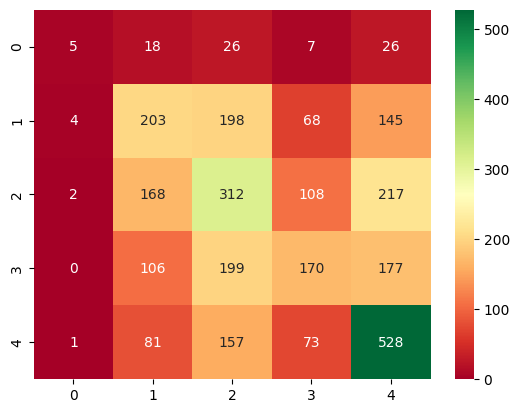

In [54]:
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_y_pred))
# Classification report
print("Classification Report:\n", classification_report(y_test, rfc_y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, rfc_y_pred))

sns.heatmap(confusion_matrix(y_test, rfc_y_pred), annot=True, fmt='d', cmap='RdYlGn')

We can see that the model does a TERRIBLE job when it comes to predicting label 0 target values, however, when it comes to label 4, the recall rate(correctly placing it on 4 - 63%). Adoption 4 is the most important group to get right!

However, let's work on the model to see if we can improve the other important group (group number 3 - 2nd & 3rd mth adoption)

#### 3.2.1 Model - Feature analysis and selection

In [55]:
feature_importances_rfc = pd.DataFrame(rfc.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

feature_importances_rfc.head(50)

,importance
Sentiment_magnitude,0.1190400787
Age,0.1003160237
PhotoAmt,0.0989170372
Sentiment_score,0.0934258009
Quantity,0.0322992205
Fee,0.0297231688
Gender_Male,0.0243094820
Color1_label_Brown,0.0236749917
Color2_label_nan,0.0224099110
Color2_label_White,0.0214324561


In [56]:
rfc_sfm = SelectFromModel(rfc)
rfc_sfm.fit(X_train, y_train)

X_train_selection = rfc_sfm.transform(X_train)
X_test_selection = rfc_sfm.transform(X_test)

0.41213737912637544
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.04      0.07        82
           1       0.35      0.33      0.34       618
           2       0.35      0.39      0.37       807
           3       0.43      0.27      0.34       652
           4       0.49      0.64      0.55       840

    accuracy                           0.41      2999
   macro avg       0.40      0.33      0.33      2999
weighted avg       0.41      0.41      0.40      2999

Confusion Matrix:
 [[  3  23  24   6  26]
 [  2 204 203  73 136]
 [  3 178 315  89 222]
 [  0 103 192 179 178]
 [  0  83 156  66 535]]


<Axes: >

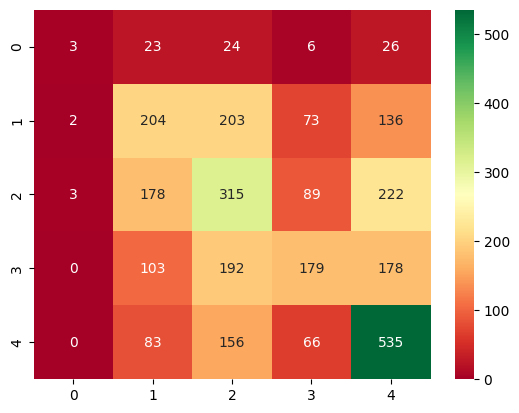

In [57]:
rfc_after_select = RandomForestClassifier(random_state=400)
rfc_after_select.fit(X_train_selection, y_train)
new_ypred_selection = rfc_after_select.predict(X_test_selection)

print(accuracy_score(y_test, new_ypred_selection))
# Classification report
print("Classification Report:\n", classification_report(y_test, new_ypred_selection))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, new_ypred_selection))

sns.heatmap(confusion_matrix(y_test, new_ypred_selection), annot=True, fmt='d', cmap='RdYlGn')

#### 3.2.2 Model - Hyperparameter tuning

In [58]:
#Fine tuning hyperparameters:

param_grid_rf = {
    'bootstrap': [True, False],         
    'max_depth': [25, 50, 75, 100], 
    'max_features': ['sqrt'],
    'min_samples_leaf': [2,3,4,5,10],    
    'min_samples_split': [5,10,15],  
    'n_estimators': [100, 200, 300]    
}

rf_grid = RandomForestClassifier(random_state=400)

grid_rf = GridSearchCV( estimator=rf_grid, param_grid=param_grid_rf, cv=3, verbose=2, n_jobs= -1, scoring='accuracy')
grid_rf.fit(X_train_selection, y_train)
grid_rf.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indic

[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.8s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   5.8s
[CV] END bootstrap=True, max_depth=25, max_featu

{'bootstrap': False,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 300}

0.41380460153384463


/home/ecotears/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ecotears/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ecotears/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.36      0.29      0.32       618
           2       0.35      0.41      0.38       807
           3       0.44      0.23      0.30       652
           4       0.48      0.69      0.56       840

    accuracy                           0.41      2999
   macro avg       0.33      0.32      0.31      2999
weighted avg       0.40      0.41      0.39      2999

Confusion Matrix:
 [[  0  22  25   5  30]
 [  0 181 218  54 165]
 [  0 148 330  89 240]
 [  0  89 209 147 207]
 [  0  57 160  40 583]]


<Axes: >

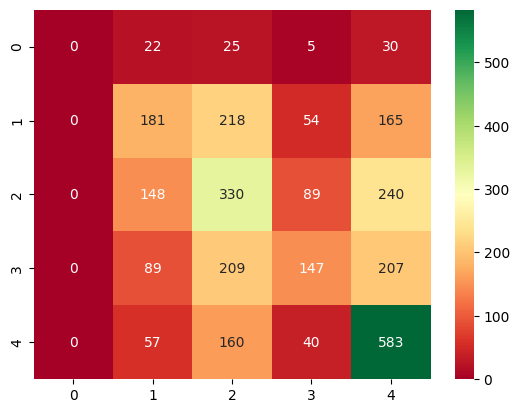

In [59]:
# Best params for accuracy:
# {'bootstrap': False,
#  'max_depth': 100,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 10,
#  'n_estimators': 300}


rf_grid_model = grid_rf.best_estimator_
y_pred_rfgrid = rf_grid_model.predict(X_test_selection)


print(accuracy_score(y_test, y_pred_rfgrid))
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rfgrid))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfgrid))

sns.heatmap(confusion_matrix(y_test, y_pred_rfgrid), annot=True, fmt='d', cmap='RdYlGn')

In [60]:
# Tried a new model where y is only 4 labels as adoption in the same day can be put into the group 1 (adoption 1st week)

y_train_newclasses = y_train.apply(lambda x: x - 1 if x != 0 else x)
y_test_newclasses = y_test.apply(lambda x: x - 1 if x != 0 else x)

0.41780593531177057
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.38      0.38       700
           1       0.35      0.35      0.35       807
           2       0.46      0.22      0.30       652
           3       0.48      0.68      0.56       840

    accuracy                           0.42      2999
   macro avg       0.42      0.40      0.39      2999
weighted avg       0.42      0.42      0.40      2999

Confusion Matrix:
 [[263 207  49 181]
 [211 280  80 236]
 [119 190 142 201]
 [103 133  36 568]]


<Axes: >

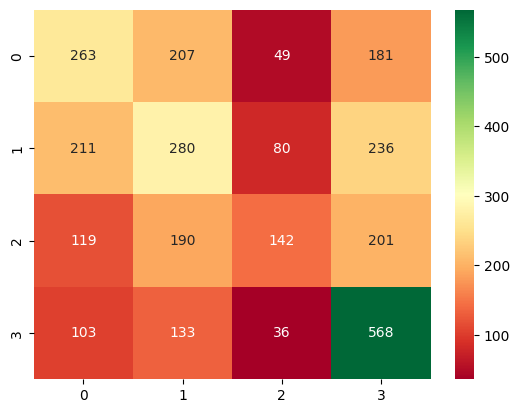

In [61]:
rf_trial = RandomForestClassifier(bootstrap = False,
 max_depth = 25,
 max_features = 'sqrt',
 min_samples_leaf = 2,
 min_samples_split= 15,
 n_estimators= 300,
 random_state=400)

rf_trial.fit(X_train_selection, y_train_newclasses)
y_newclasses_predict = rf_trial.predict(X_test_selection)

print(accuracy_score(y_test_newclasses, y_newclasses_predict))
# Classification report
print("Classification Report:\n", classification_report(y_test_newclasses, y_newclasses_predict))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_newclasses, y_newclasses_predict))

sns.heatmap(confusion_matrix(y_test_newclasses, y_newclasses_predict), annot=True, fmt='d', cmap='RdYlGn')

### 3.3 Model - Base XGBoost

0.41113704568189396
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.04      0.06        82
           1       0.38      0.33      0.35       618
           2       0.34      0.42      0.38       807
           3       0.39      0.20      0.27       652
           4       0.50      0.66      0.57       840

    accuracy                           0.41      2999
   macro avg       0.37      0.33      0.33      2999
weighted avg       0.40      0.41      0.39      2999

Confusion Matrix:
 [[  3  18  33   9  19]
 [  4 202 220  62 130]
 [  3 143 341  93 227]
 [  1  91 242 133 185]
 [  2  80 157  47 554]]


<Axes: >

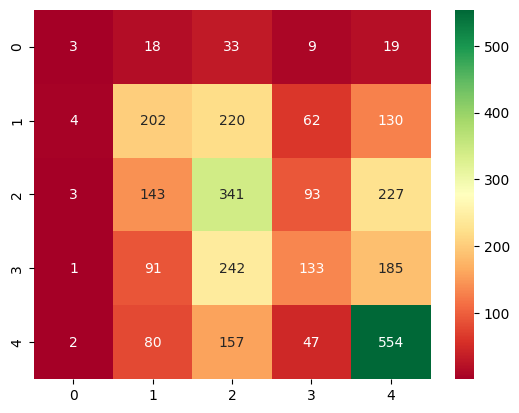

In [62]:
xgb_c = xgb.XGBClassifier(objective='multi:softmax', random_state= 400)
xgb_c.fit(X_train, y_train)

xgb_y_pred = xgb_c.predict(X_test)


print(accuracy_score(y_test, xgb_y_pred))
# Classification report
print("Classification Report:\n", classification_report(y_test, xgb_y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))

sns.heatmap(confusion_matrix(y_test, xgb_y_pred), annot=True, fmt='d', cmap='RdYlGn')

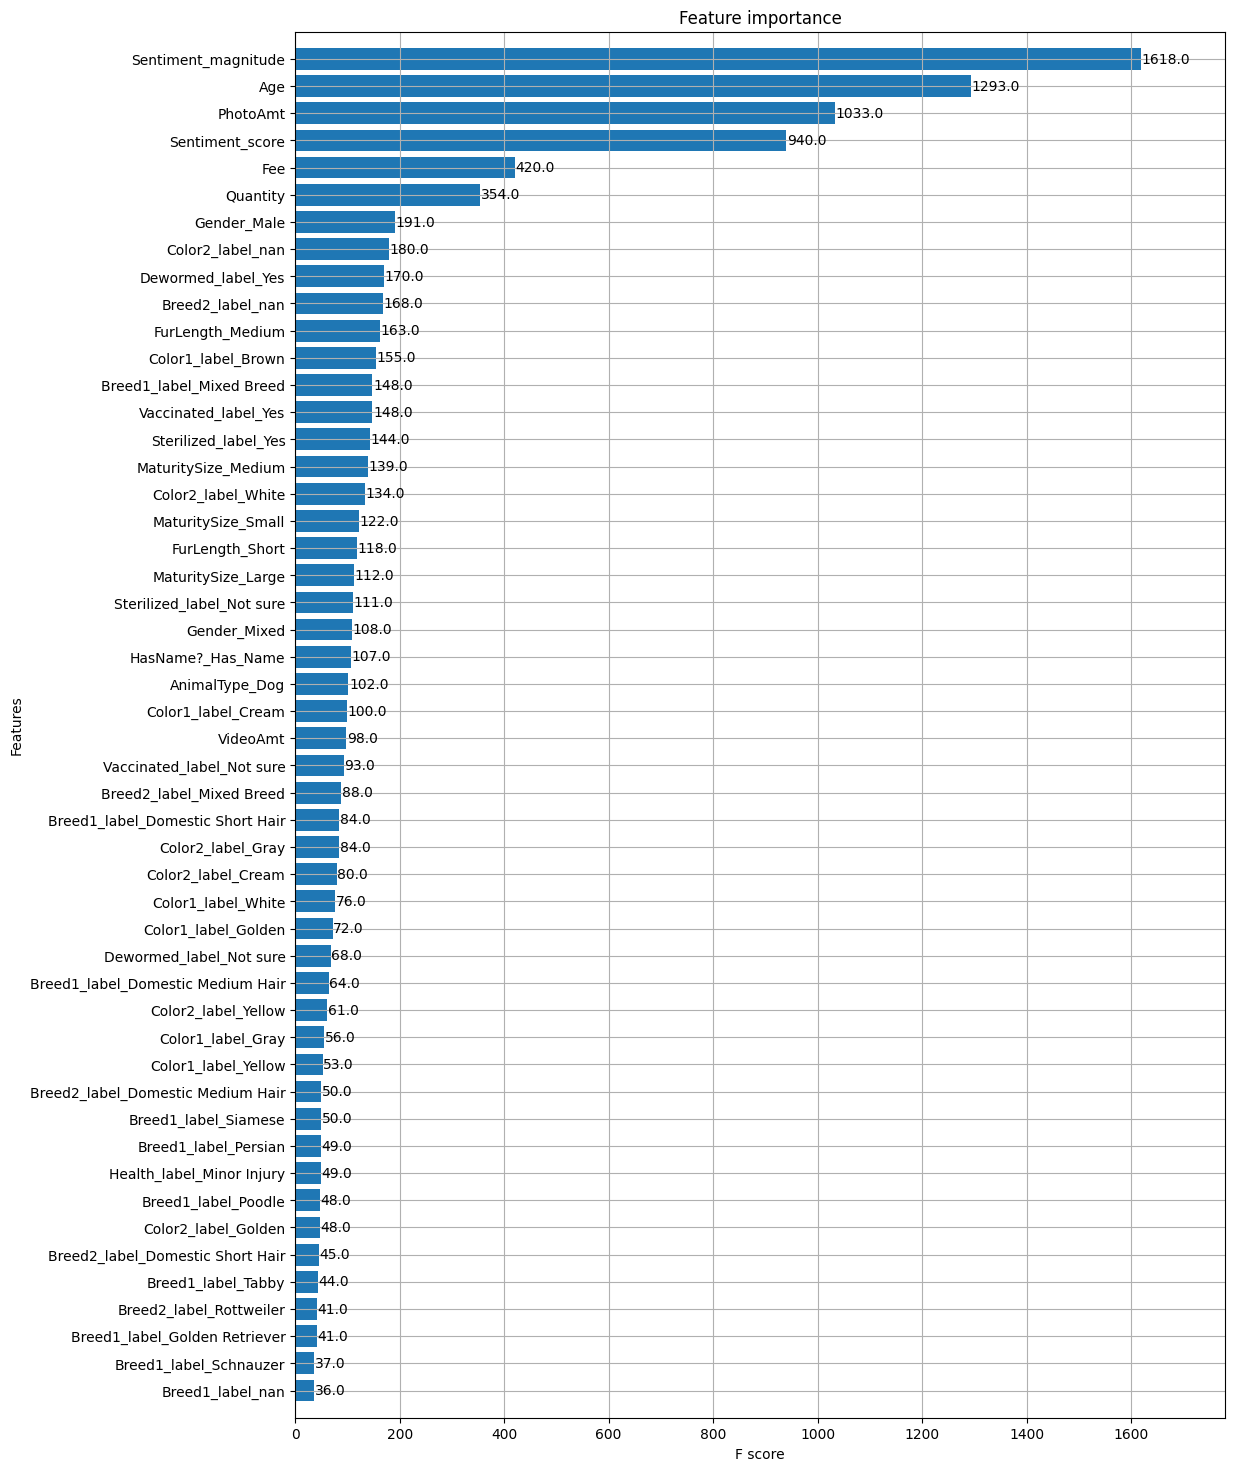

In [63]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb_c, max_num_features=50, height=0.8, ax=ax)
plt.show()

#### 3.2.1 Model - Feature analysis and selection

In [64]:
feature_importances_xgb = pd.DataFrame(xgb_c.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

feature_importances_xgb.head(50)

,importance
Breed1_label_Mixed Breed,0.0372535102
AnimalType_Dog,0.0171795711
Sterilized_label_Not sure,0.0167343616
Sterilized_label_Yes,0.0145532377
Age,0.0129410904
Breed2_label_Mixed Breed,0.0119348429
MaturitySize_Small,0.0109377494
Quantity,0.0108488221
Breed2_label_Terrier,0.0099263666
PhotoAmt,0.0099158734


In [65]:
importance = xgb_c.feature_importances_
percentile_50_importance = np.percentile(importance, 50)

selected_features = feature_importances_xgb[feature_importances_xgb['importance'] >= percentile_50_importance].index

In [66]:
X_train_select_xgb = X_train[selected_features]
X_test_select_xgb = X_test[selected_features]

0.40146715571857283
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.04      0.06        82
           1       0.37      0.32      0.35       618
           2       0.33      0.41      0.36       807
           3       0.37      0.19      0.25       652
           4       0.49      0.65      0.56       840

    accuracy                           0.40      2999
   macro avg       0.35      0.32      0.32      2999
weighted avg       0.39      0.40      0.38      2999

Confusion Matrix:
 [[  3  19  32   9  19]
 [  4 200 231  53 130]
 [  4 146 330  94 233]
 [  1  94 254 122 181]
 [  3  76 158  54 549]]


<Axes: >

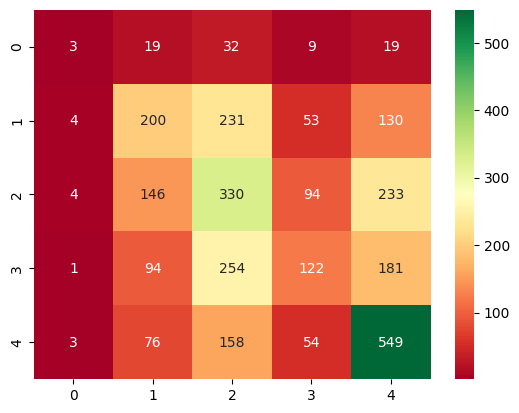

In [67]:
# It seems that deleting features makes it slightly worse indeed.

xgb_c_2 = xgb.XGBClassifier(objective='multi:softmax', random_state=400)
xgb_c_2.fit(X_train_select_xgb, y_train)

xgb_y_pred_2 = xgb_c_2.predict(X_test_select_xgb)


print(accuracy_score(y_test, xgb_y_pred_2))
# Classification report
print("Classification Report:\n", classification_report(y_test, xgb_y_pred_2))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred_2))

sns.heatmap(confusion_matrix(y_test, xgb_y_pred_2), annot=True, fmt='d', cmap='RdYlGn')

#### 3.2.2 Model - Hyperparameter tuning

In [68]:
param_grid_xgb = {
'objective' : ['multi:softmax'],
'eta' : [0.01],
'max_depth' : [3, 4, 6],
'min_child_weight' : [2, 3, 4],
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.1],
'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_c, param_grid=param_grid_xgb, scoring='accuracy',cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best score found: ", grid_search_xgb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   4.9s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   4.9s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   5.0s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   5.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   5.5s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   5.6s
[CV] END eta=0.01, learning_rate=0.01, max_

0.40780260086695563
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.01      0.02        82
           1       0.40      0.33      0.36       618
           2       0.34      0.45      0.39       807
           3       0.38      0.16      0.23       652
           4       0.48      0.66      0.56       840

    accuracy                           0.41      2999
   macro avg       0.35      0.32      0.31      2999
weighted avg       0.40      0.41      0.38      2999

Confusion Matrix:
 [[  1  22  35   5  19]
 [  1 202 235  38 142]
 [  2 129 361  82 233]
 [  2  86 262 107 195]
 [  0  69 169  50 552]]


<Axes: >

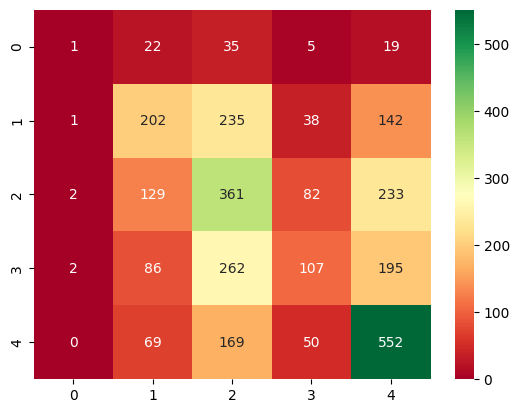

In [69]:
best_xgb = grid_search_xgb.best_estimator_

y_pred_best_xgb = best_xgb.predict(X_test)

print(accuracy_score(y_test, y_pred_best_xgb))
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))

sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', cmap='RdYlGn')

0.4251417139046349
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.41      0.41       700
           1       0.35      0.40      0.37       807
           2       0.39      0.17      0.24       652
           3       0.50      0.66      0.57       840

    accuracy                           0.43      2999
   macro avg       0.42      0.41      0.40      2999
weighted avg       0.42      0.43      0.41      2999

Confusion Matrix:
 [[286 228  41 145]
 [184 323  77 223]
 [121 235 111 185]
 [ 89 142  54 555]]


<Axes: >

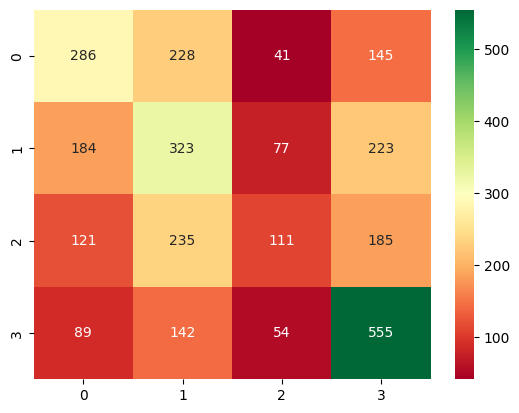

In [70]:
xgb_c_3 = xgb.XGBClassifier(
    eta = 0.01,
    learning_rate = 0.1, 
    max_depth = 4, 
    min_child_weight = 4, 
    n_estimators = 200, 
    objective = 'multi:softmax', 
    subsample = 0.8,random_state = 400
    )
xgb_c_3.fit(X_train, y_train_newclasses)

xgb_y_pred_3 = xgb_c_3.predict(X_test)


print(accuracy_score(y_test_newclasses, xgb_y_pred_3))
# Classification report
print("Classification Report:\n", classification_report(y_test_newclasses, xgb_y_pred_3))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_newclasses, xgb_y_pred_3))

sns.heatmap(confusion_matrix(y_test_newclasses, xgb_y_pred_3), annot=True, fmt='d', cmap='RdYlGn')

## 4. Final model and evaluation

In [76]:
print(X_train.columns)

Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Sentiment_score',
       'Sentiment_magnitude', 'Gender_Male', 'Gender_Mixed',
       'MaturitySize_Large',
       ...
       'Breed2_label_Tortoiseshell', 'Breed2_label_Turkish Angora',
       'Breed2_label_Turkish Van', 'Breed2_label_Tuxedo',
       'Breed2_label_Weimaraner', 'Breed2_label_Welsh Corgi',
       'Breed2_label_Wirehaired Terrier',
       'Breed2_label_Yellow Labrador Retriever',
       'Breed2_label_Yorkshire Terrier Yorkie', 'Breed2_label_nan'],
      dtype='object', length=341)


In [97]:
# Let's build the final models using GridSearch and 4 classes now only (so now 4 --> 3, 3 --> 2, 2 --> 1, 1 and 0 --> 0)

#Random Forest:

param_grid_rf_final = {
    'bootstrap': [True, False],         
    'max_depth': [25, 50, 75, 100], 
    'max_features': ['sqrt'],
    'min_samples_leaf': [2,3,4,5,10],    
    'min_samples_split': [5,10,15],  
    'n_estimators': [100, 200, 300]    
}

rf_grid_final = RandomForestClassifier(random_state=400)

grid_rf_final = GridSearchCV(estimator=rf_grid_final, param_grid=param_grid_rf, cv=3, verbose=2, n_jobs= -1, scoring='accuracy')
grid_rf_final.fit(X_train_selection, y_train_newclasses)
grid_rf.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indic

[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   4.5s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   4.5s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   4.5s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=25, max_feat

/home/ecotears/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': False,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 300}

0.42447482494164723
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.38      0.39       700
           1       0.36      0.36      0.36       807
           2       0.49      0.20      0.29       652
           3       0.47      0.69      0.56       840

    accuracy                           0.42      2999
   macro avg       0.43      0.41      0.40      2999
weighted avg       0.43      0.42      0.41      2999

Confusion Matrix:
 [[269 212  37 182]
 [199 294  71 243]
 [118 182 132 220]
 [ 95 138  29 578]]


<Axes: >

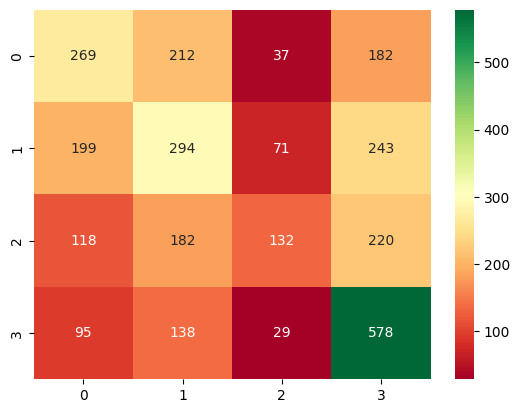

In [101]:
rf_grid_model_final = grid_rf_final.best_estimator_
y_pred_rfgrid_final = rf_grid_model_final.predict(X_test_selection)


print(accuracy_score(y_test_newclasses, y_pred_rfgrid_final))
# Classification report
print("Classification Report:\n", classification_report(y_test_newclasses, y_pred_rfgrid_final))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_newclasses, y_pred_rfgrid_final))

sns.heatmap(confusion_matrix(y_test_newclasses, y_pred_rfgrid_final), annot=True, fmt='d', cmap='RdYlGn')

In [99]:
# Final XGB:
Final_xgb = xgb.XGBClassifier(random_state = 400)
Final_xgb.fit(X_train, y_train_newclasses)

param_grid_xgb = {
'objective' : ['multi:softmax'],
'eta' : [0.01],
'max_depth' : [3, 4, 6],
'min_child_weight' : [2, 3, 4],
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.1],
'subsample': [0.8, 1.0]
}

grid_search_xgb_final = GridSearchCV(estimator=Final_xgb, param_grid=param_grid_xgb, scoring='accuracy',cv=3, n_jobs=-1, verbose=2)
grid_search_xgb_final.fit(X_train, y_train_newclasses)

print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best score found: ", grid_search_xgb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   4.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   4.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   4.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   4.2s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   4.2s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   4.3s
[CV] END eta=0.01, learning_rate=0.01, max_

/home/ecotears/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, objective=multi:softmax, subsample=1.0; total time=  11.9s


/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, objective=multi:softmax, subsample=1.0; total time=  12.2s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, objective=multi:softmax, subsample=0.8; total time=   5.0s


[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   6.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   6.4s


/home/ecotears/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, objective=multi:softmax, subsample=1.0; total time=   7.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:softmax, subsample=0.8; total time=  10.9s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:softmax, subsample=0.8; total time=   9.8s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:softmax, subsample=1.0; total time=   9.1s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:softmax, subsample=0.8; total time=   9.4s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:softmax, subsample=1.0; total time=   9.5s
[CV] END eta=0.01, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, objective=multi:

0.41647215738579524
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.39      0.40       700
           1       0.34      0.40      0.37       807
           2       0.39      0.17      0.24       652
           3       0.50      0.64      0.56       840

    accuracy                           0.42      2999
   macro avg       0.41      0.40      0.39      2999
weighted avg       0.41      0.42      0.40      2999

Confusion Matrix:
 [[273 236  48 143]
 [184 324  77 222]
 [119 239 111 183]
 [ 90 160  49 541]]


<Axes: >

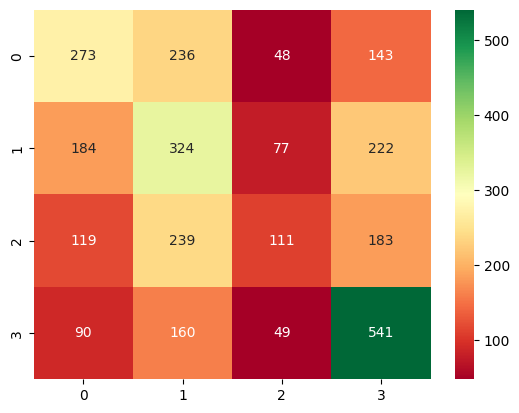

In [100]:
best_xgb_final = grid_search_xgb_final.best_estimator_

y_pred_best_xgb_2 = best_xgb_final.predict(X_test)

print(accuracy_score(y_test_newclasses, y_pred_best_xgb_2))
# Classification report
print("Classification Report:\n", classification_report(y_test_newclasses, y_pred_best_xgb_2))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_newclasses, y_pred_best_xgb_2))

sns.heatmap(confusion_matrix(y_test_newclasses, y_pred_best_xgb_2), annot=True, fmt='d', cmap='RdYlGn')

## 5. Saving the model

In [103]:
print(numerical_columns)
print(categorical_columns)

X_output = adoption_df_model.drop(columns='AdoptionSpeed')
y_output = np.where(adoption_df_model['AdoptionSpeed'] == 0, 0, adoption_df_model['AdoptionSpeed'] -1 )


X_train_output, X_test_output, y_train_output, y_test_output = train_test_split(X_output, y_output, test_size=0.2, stratify=y, random_state=400)

best_rf_parameters ={
'bootstrap': False,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 300} 

pipeline = Pipeline(steps=[
    ('preprocessing', ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])),
    ('feature_selection',SelectFromModel(RandomForestClassifier(random_state=400))),
    ('Classifier', RandomForestClassifier(random_state=400, **best_rf_parameters))
])

pipeline.fit(X_train_output, y_train_output)




Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Sentiment_score',
       'Sentiment_magnitude'],
      dtype='object')
Index(['Gender', 'MaturitySize', 'FurLength', 'HasName?', 'AnimalType',
       'Vaccinated_label', 'Dewormed_label', 'Sterilized_label',
       'Health_label', 'Color1_label', 'Color2_label', 'Breed1_label',
       'Breed2_label'],
      dtype='object')


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Sentiment_score',
       'Sentiment_magnitude'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'MaturitySize', 'FurLength', 'HasName?', 'AnimalType',
       'Vaccinated_label', 'Dewormed_l...', 'Sterilized_label',
       'Health_label', 'Color1_label', 'Color2_label', 'Breed1_label',
       'Breed2_label'],
      dtype='object'))])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=400))),
                ('Classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        min_samples_leaf=2,
                                        min_samples_split=15, n_estimators=300,
                                        random_state=400))])

0.4214738246082027
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.39      0.39       700
           1       0.35      0.35      0.35       807
           2       0.45      0.22      0.29       652
           3       0.48      0.68      0.56       840

    accuracy                           0.42      2999
   macro avg       0.42      0.41      0.40      2999
weighted avg       0.42      0.42      0.41      2999

Confusion Matrix:
 [[270 202  59 169]
 [200 282  86 239]
 [111 192 143 206]
 [102 136  33 569]]


<Axes: >

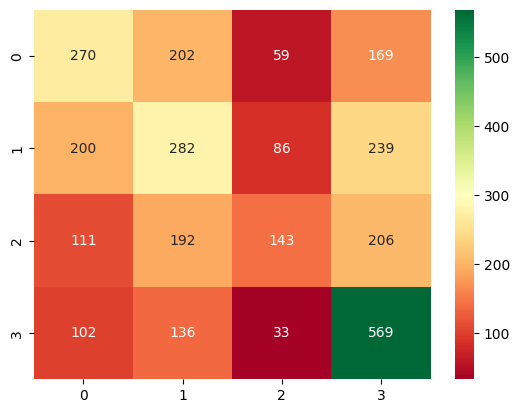

In [104]:
y_pred_2222 = pipeline.predict(X_test_output)

print(accuracy_score(y_test_output, y_pred_2222))
# Classification report
print("Classification Report:\n", classification_report(y_test_output, y_pred_2222))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_output, y_pred_2222))

sns.heatmap(confusion_matrix(y_test_output, y_pred_2222), annot=True, fmt='d', cmap='RdYlGn')

In [107]:
joblib.dump(pipeline, 'final_randomforest_model.joblib')

['final_randomforest_model.joblib']

In [128]:
adoption_df_model.tail(20).to_csv('rows_for_testing.csv', index=False)
